#  Series temporales. Modelos de Suavizado exponencial y ARIMA

En este documento exploramos distintos modelos de suavizado y ARIMA para series univariantes. Este código servirá para los días 5 y 6 ya que resulta cómodo e ilustrativo aplicar todos los métodos a cada conjunto de datos y poder comparar los resultados. 

La idea será buscar los mejores modelos para la predicción de series temporales para los datos que nos lleguen.

# Series temporales I. Suavizado

En esta primera sesión vamos a explorar los métodos de inspección descriptiva de una serie temporal y, posteriormente, los primeros modelos predictivos basados en suavizado exponencial. 

El esquema de trabajo será: 

1. Leer valores de la serie y convertir a formato legible por python
2. Representar la serie para intuir componentes presentes
3. Descomposición de la serie y contraste de estacionariedad
4. Creación de partición en ventanas training/test
5. Aplicación de modelos de suavizado y evaluación de ajuste

Con esto tendremos una primera aproximación para la predicción de datos a futuro en una serie temporal univariante.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

#from rpy2.robjects.packages import importr, data
  
#datasets = importr('datasets')
#AirPassengers = pd.Series(data(datasets).fetch('AirPassengers')['AirPassengers'])
AirPassengers=pd.read_csv('AirPassengers.csv',index_col=0)
AirPassengers

Passengers
Month              
1949-01         112
1949-02         118
1949-03         132
1949-04         129
1949-05         121
...             ...
1960-08         606
1960-09         508
1960-10         461
1960-11         390
1960-12         432

[144 rows x 1 columns]

Asignamos manualmente la fecha de inicio a fin en intervalos mensuales ya que esta lectura no devuelve las fechas correctamente.. (tenemos de todas formas el csv en la carpeta por si lo necesitáramos). Con date_range generamos las fechas.



In [2]:
fechas = pd.date_range('1949-01-01','1960-12-01', 
               freq='MS').strftime("%Y-%m").tolist()
fechas = pd.Series(fechas)
fechas

0      1949-01
1      1949-02
2      1949-03
3      1949-04
4      1949-05
        ...   
139    1960-08
140    1960-09
141    1960-10
142    1960-11
143    1960-12
Length: 144, dtype: object

Unimos las fechas a los valores de la serie.



In [3]:
# Unir en un data
Air_R = pd.concat([fechas,AirPassengers], axis=1)
Air_R.columns = ['Month','Passengers']
Air_R.head()

Month  Passengers
0  1949-01         NaN
1  1949-02         NaN
2  1949-03         NaN
3  1949-04         NaN
4  1949-05         NaN

Check! 



In [4]:
# Lo leemos desde el csv que desde R en el propio R colapsa el espacio-tiempo jeje
Air = pd.read_csv('AirPassengers.csv')
Air.head()

Air.head()


Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121

Convertimos a serie temporal para que python entienda con una simple asignación de la variable de fecha 'Month' en formato datetime por si acaso. 



In [5]:
# Convertir en serie temporal
Air.set_index(['Month'],inplace=True)
Air.index=pd.to_datetime(Air.index)


A ver cuál es el aspecto.. 



In [6]:
Air



Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

Ya tenemos la serie preparada para analizar. En primer luegar haremos un estudio descriptivo, pintar, descomponer, entender las componentes y tal vez echar un vistazo a los correlogramas y tests de estacionariedad para los residuos de la descomposición "inocente" con la simple extracción de componentes. 

## Estudio descriptivo

Aquí opción gráfica para que los plot() salgan grandes. 


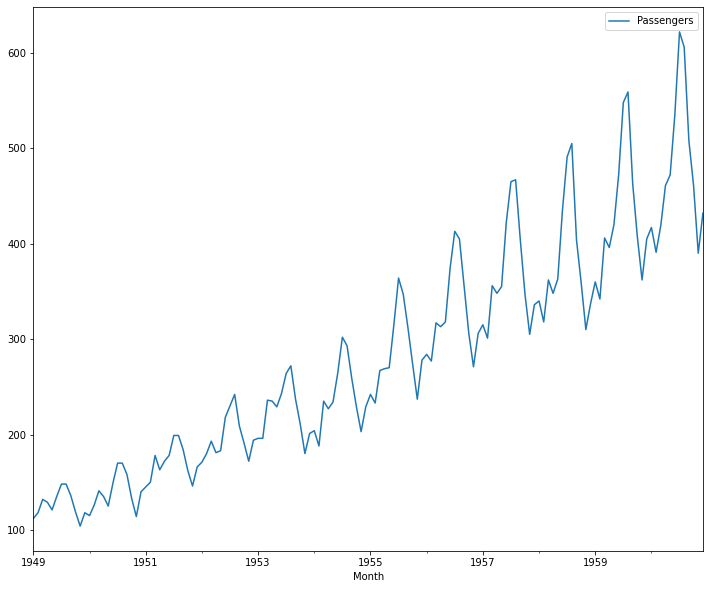

In [7]:
plt.rcParams["figure.figsize"] = (12,10)
Air.plot()
plt.show()


Podemos definir una función que calcule el test de Dickey Fuller para la estacionariedad de la serie. De esta forma, en cualquier momento, introduciendo el vector de valores de la serie, obtendremos el contraste de hipótesis. 

H0: La serie NO es estacionaria
H1: La serie es estacionaria

Por tanto, nos interesará que el contraste de hipótesis sea rechazado (p-valor < 0.05). 


In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


Probamos con la serie al natural. 



In [9]:
test_stationarity(Air)



Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Descomposición de la serie

En base a la descomposición descriptiva por medias móviles, se extraen las componentes de tendencia y estacionalidad.

**Descomposición aditiva** 


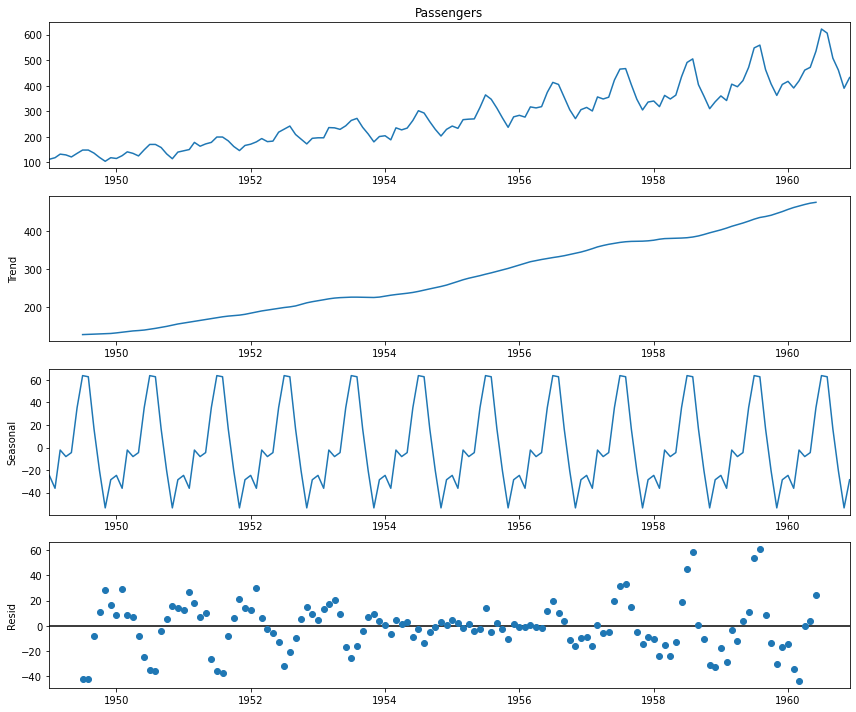

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicar descomposición aditiva
Air_desc_Ad = seasonal_decompose(Air['Passengers'], model='additive',period=12)
Air_desc_Ad.plot()
plt.show()


Evaluamos estacionariedad de los residuos de la descomposición aditiva. Aquí, debido a que la tendencia se calcula por medias móviles, los primeros y últimos valores de la serie son NA, no se calculan. Simplemente saber esto y tener en cuenta solamente los residuos válidos. 



In [11]:
test_stationarity(Air_desc_Ad.resid.dropna())



Results of Dickey-Fuller Test:
Test Statistic                  -5.298428
p-value                          0.000006
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


**Descomposición multiplicativa** 



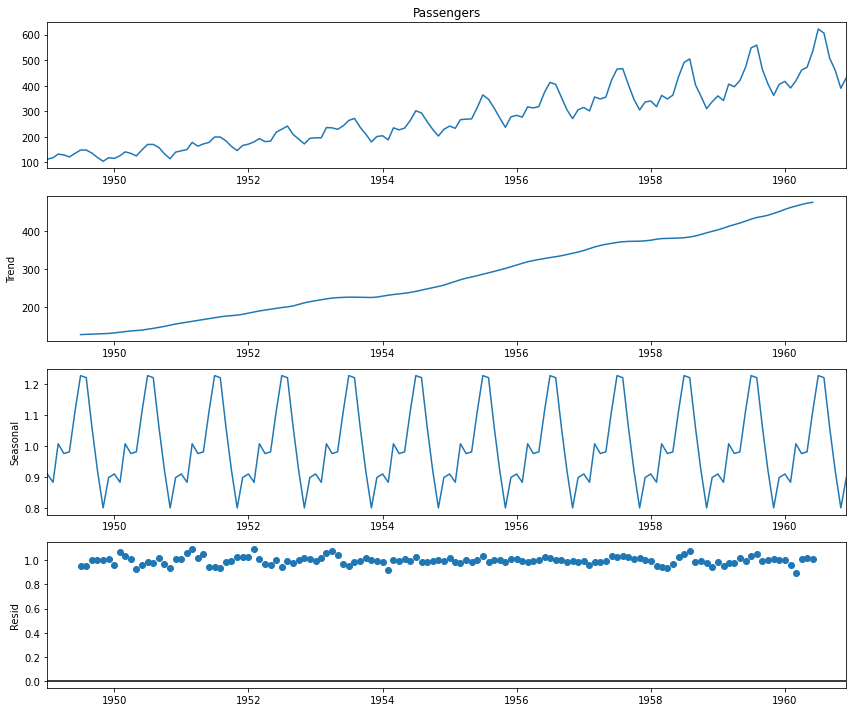

In [12]:
# Aplicar descomposición aditiva
Air_desc_Mul = seasonal_decompose(Air['Passengers'], model='multiplicative',period=12)
Air_desc_Mul.plot()
plt.show()


Evaluamos estacionariedad de los residuos de la descomposición Multiplicativa. 



In [13]:
test_stationarity(Air_desc_Mul.resid.dropna())



Results of Dickey-Fuller Test:
Test Statistic                -7.415925e+00
p-value                        6.936029e-11
#Lags Used                     7.000000e+00
Number of Observations Used    1.240000e+02
Critical Value (1%)           -3.484220e+00
Critical Value (5%)           -2.885145e+00
Critical Value (10%)          -2.579359e+00
dtype: float64


In [14]:
def seasonal_plot(df, season='year', index='month', column=None):
    """Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    
    Arguments:
    
    - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,8))


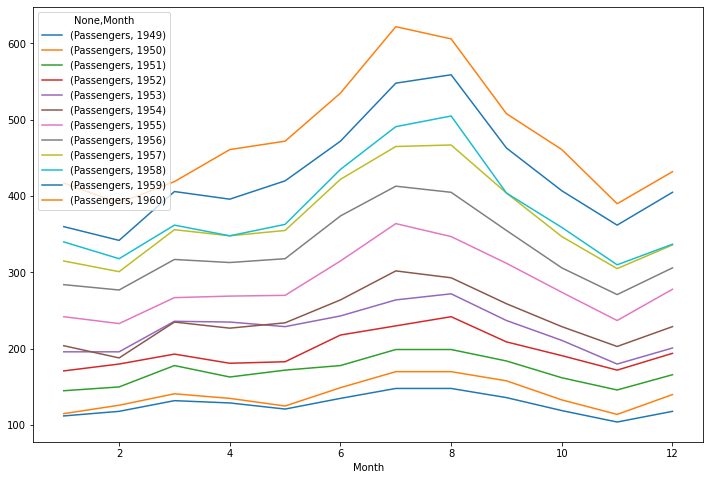

In [15]:
seasonal_plot(Air)
plt.show()


### Hacia la estacionariedad

En esta sección vamos a extraer las componentes identificadas para generar una serie residual y comprobar si es estacionaria una vez eliminados los efectos típicos de las series temporales. 

El esquema es: 

1. Estabilización de la varianza. Transformación Logaritmica
2. Diferenciación regular
3. Diferenciación estacional

Con la serie resultante, comprobaremos estacionariedad y será con la que podemos valorar autocorrelaciones simples y parciales para proponer órdenes ARIMA tentativos par la serie.

#### Estabilización de la varianza. Transformación Logaritmica


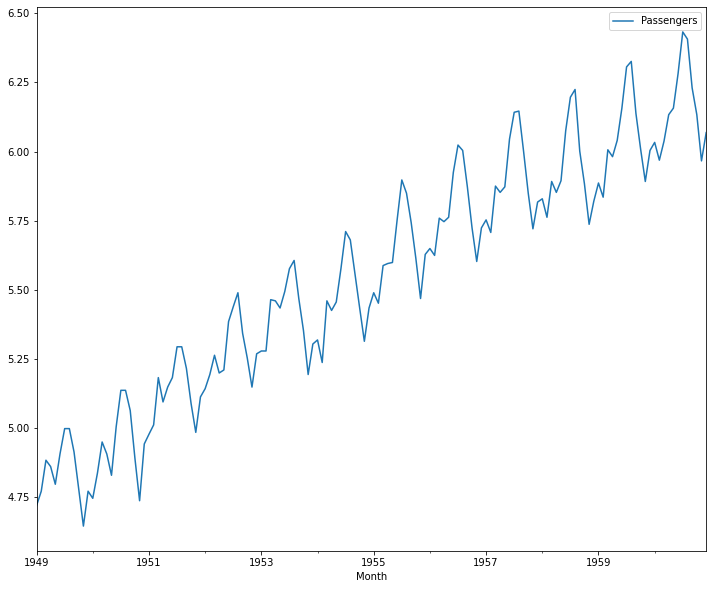

In [16]:
AirLog = np.log(Air)
AirLog.plot()
plt.show()


#### Diferenciación regular



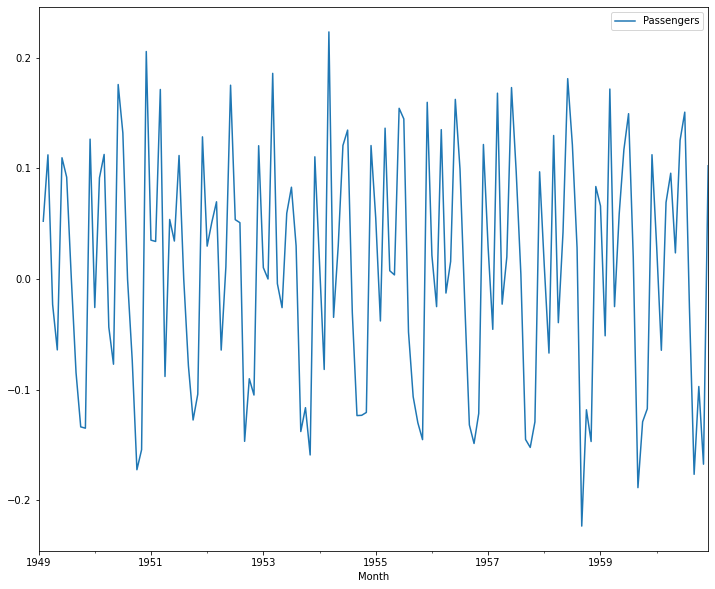

In [17]:
AirLog_diff_1 = AirLog.diff(periods=1)
AirLog_diff_1.plot()
plt.show()


#### Diferenciación estacional



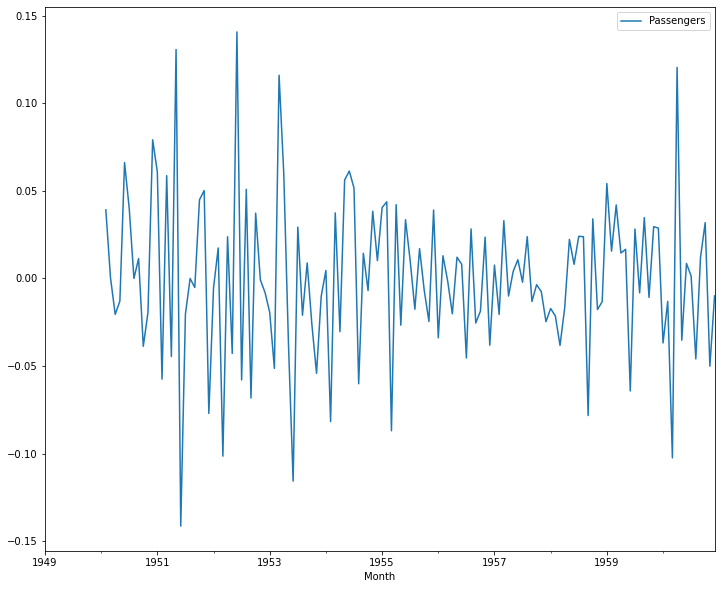

In [18]:
AirLog_diff_1_12 = AirLog_diff_1.diff(periods=12)
AirLog_diff_1_12.plot()
plt.show()


#### Comprobación de estacionariedad



In [19]:
test_stationarity(AirLog_diff_1_12.dropna(inplace=False))



Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


#### Autocorrelaciones 



In [20]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


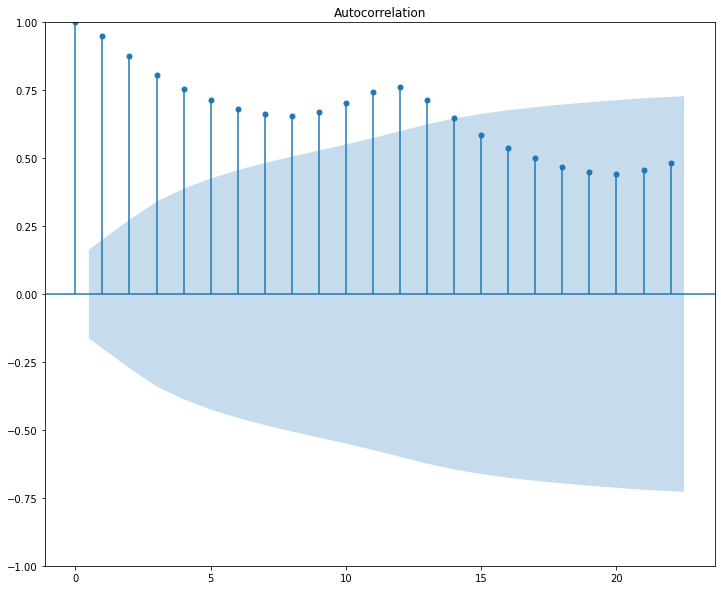

In [21]:
plot_acf(Air.dropna(inplace=False))
plt.show()


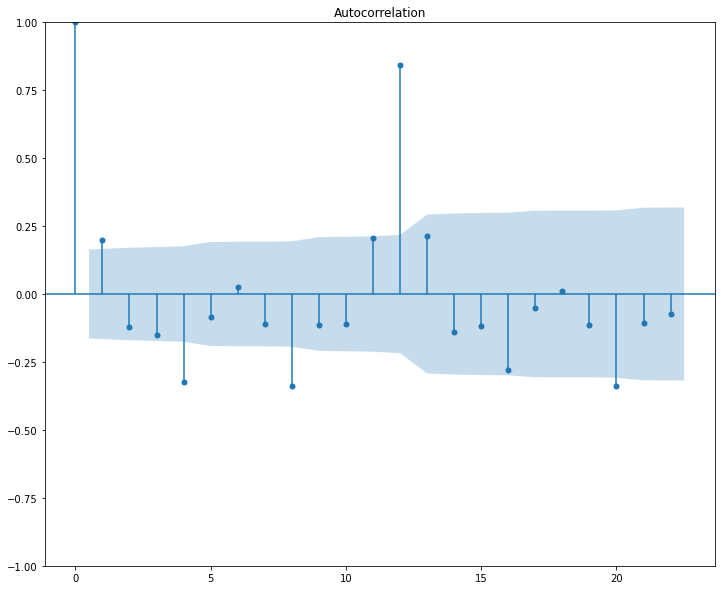

In [22]:
plot_acf(AirLog_diff_1.dropna(inplace=False))
plt.show()


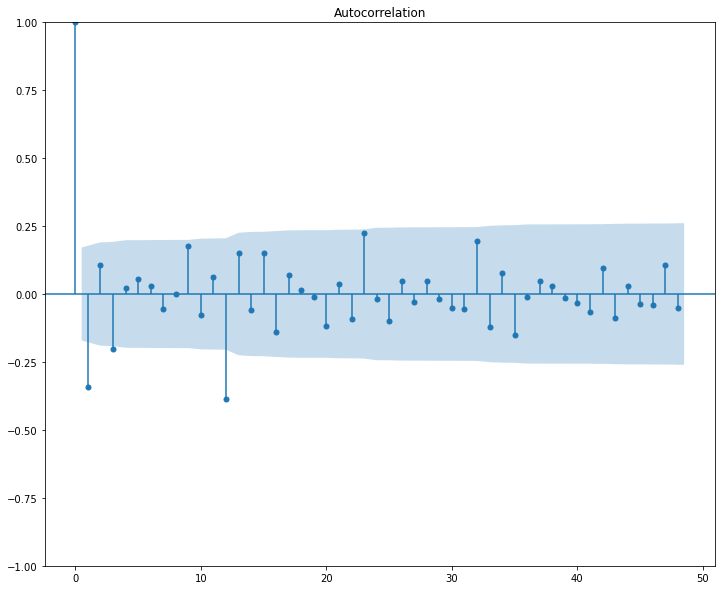

In [23]:
plot_acf(AirLog_diff_1_12.dropna(inplace=False), lags=48)
plt.show()


In [24]:
# Tets Ljung-box
sm.stats.acorr_ljungbox(AirLog_diff_1_12.dropna(inplace=False), lags=[10], return_df=True)


lb_stat  lb_pvalue
10  28.986885   0.001252

In [25]:
sm.stats.acorr_ljungbox(Air, lags=[10], return_df=True)



lb_stat      lb_pvalue
10  857.068639  1.100789e-177

## Modelos de suavizado

Exploramos ahora los distintos métodos de suavizado estudiados sobre la serie de pasajeros de avión. Antes de nada, tomamos las ventanas de training y test para ajuste y evaluación del modelo, respectivamente. 


In [1]:
import statsmodels.tsa.holtwinters as ets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Generamos la serie logaritmica
AirLog = Air.copy()
AirLog['Passengers'] = np.log(AirLog['Passengers'])
AirLog


Air_tr = AirLog[:'1958-12-01']
Air_tst = AirLog['1959-01-01':]
Air_tst

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


NameError: name 'Air' is not defined

Definimos aquí una función para evaluar un modelo (será válido para modelos de suavizado y arima de statsmodels pero no para auto_arima...distintos valores de salida y ajustaremos luego la función para ello)



In [27]:
#forecast_accuracy(fc, test.values)

# Función para evaluar modelo
def eval_model(model,tr,tst,name='Model',lags=12):
    lb = np.mean(sm.stats.acorr_ljungbox(model.resid, lags=lags, return_df=True).lb_pvalue)
    pred = model.forecast(steps=len(tst))
    fig1, ax = plt.subplots()
    ax.plot(tr, label='training')
    ax.plot(tst, label='test')
    ax.plot(pred, label='prediction')
    plt.legend(loc='upper left')
    tit = name + ":  LjungBox p-value --> " + str(lb) + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
    plt.title(tit)
    plt.ylabel('Pasajeros')
    plt.xlabel('Date')
    plt.show()
    print(lb)
 


#### Suavizado Simple

Suavizado simple, ya sabemos que no va a ajustar bien pues es para series sin tendencia y estacionalidad. Solo por ver como ajustarlo en caso de necesidad. Esperamos predicciones constantes para la ventana de test. 


In [28]:
ses = ets.SimpleExpSmoothing(Air_tr).fit()

ses.summary()

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  120
Model:             SimpleExpSmoothing   SSE                              1.332
Optimized:                       True   AIC                           -536.073
Trend:                           None   BIC                           -530.498
Seasonal:                        None   AICC                          -535.725
Seasonal Periods:                None   Date:                 Wed, 01 Mar 2023
Box-Cox:                        False   Time:                         17:43:29
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              4.7184989                  l.0                 True
------------------------------------------------------------------------------
"""

Evaluación del modelo SES.



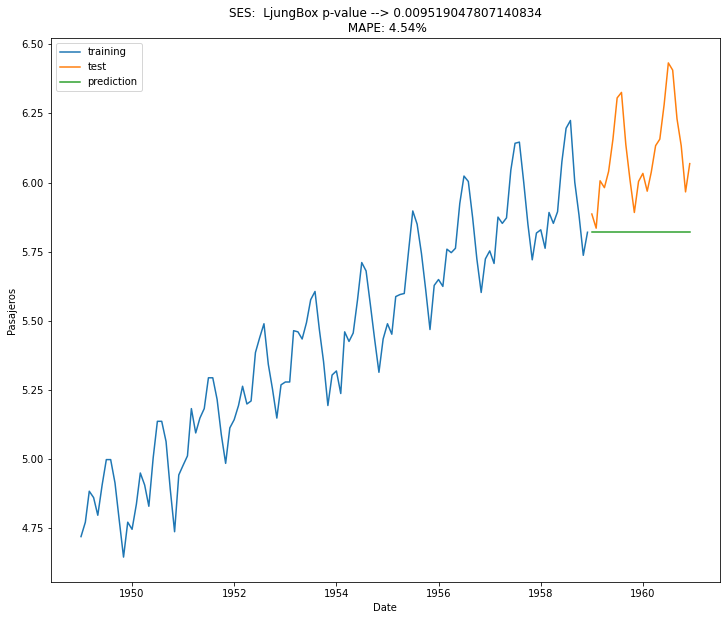

0.009519047807140834


In [29]:
# Evaluar SES
eval_model(ses,Air_tr,Air_tst,'SES')


#### Suavizado doble de Holt

Suavizado doble de Holt, con pendiente pero sin componente estacional. Esperamos una recta con pendiente como predicción.


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                              Holt Model Results                              
Dep. Variable:             Passengers   No. Observations:                  120
Model:                           Holt   SSE                              1.322
Optimized:                       True   AIC                           -532.995
Trend:                       Additive   BIC                           -521.845
Seasonal:                        None   AICC                          -532.252
Seasonal Periods:                None   Date:                 Wed, 01 Mar 2023
Box-Cox:                        False   Time:                         17:43:30
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend             0.000000                

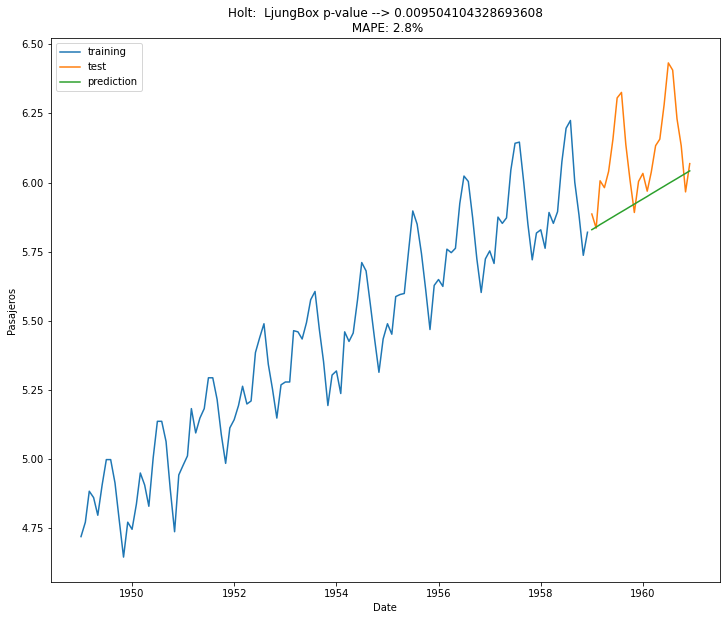

0.009504104328693608


In [30]:
# Suavizado de Holt
holt = ets.Holt(Air_tr).fit()
print(holt.summary())

eval_model(holt,Air_tr,Air_tst,'Holt')


#### Suavizado de Holt Winters Aditivo

Ahora si, vamos a los métodos que podrían funcionar sobre esta serie. En primer lugar, Holt Winters aditivo. Con el aspecto de la serie y la clara heterocedasticidad, no parece que sea la mejor opción...pero probad con el logaritmo veréis que cambio. 


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


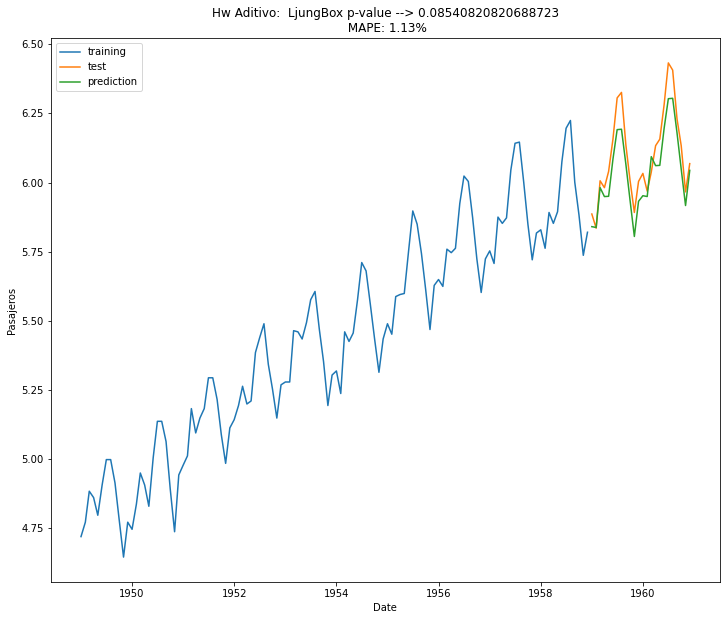

0.08540820820688723


In [31]:
hw_add = ets.ExponentialSmoothing(Air_tr,trend='add', damped_trend=False, seasonal='add').fit()
hw_add.summary()

eval_model(hw_add,Air_tr,Air_tst,'Hw Aditivo')


#### Suavizado de Holt Winters Multiplicativo

Suavizado multiplicativo para captar la componente estacional no constante con el tiempo. 


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


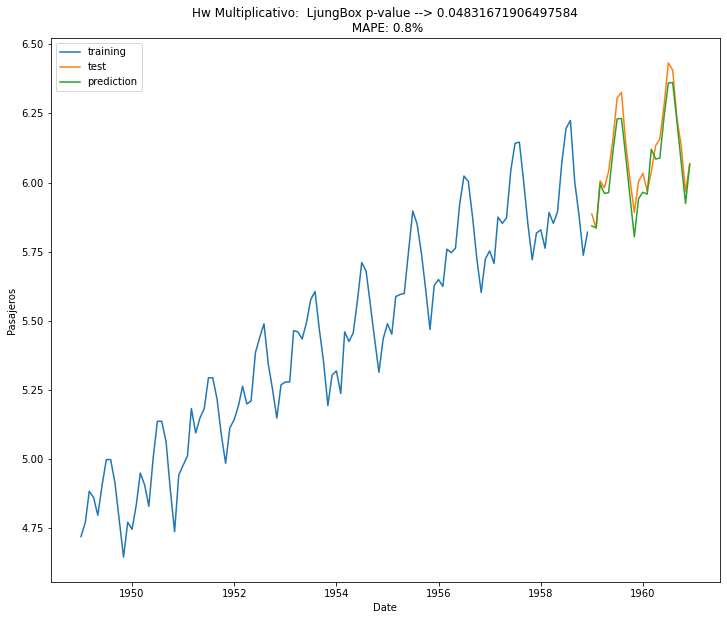

0.04831671906497584


In [32]:
hw_mul = ets.ExponentialSmoothing(Air_tr,trend='mul', damped_trend=False, seasonal='mul').fit()
hw_mul.summary()

eval_model(hw_mul,Air_tr,Air_tst,'Hw Multiplicativo')


#### Autocorrelaciones con intervalos de confianza

Podemos evaluar los correlogramas de los residuos para este último modelo multiplicativo.


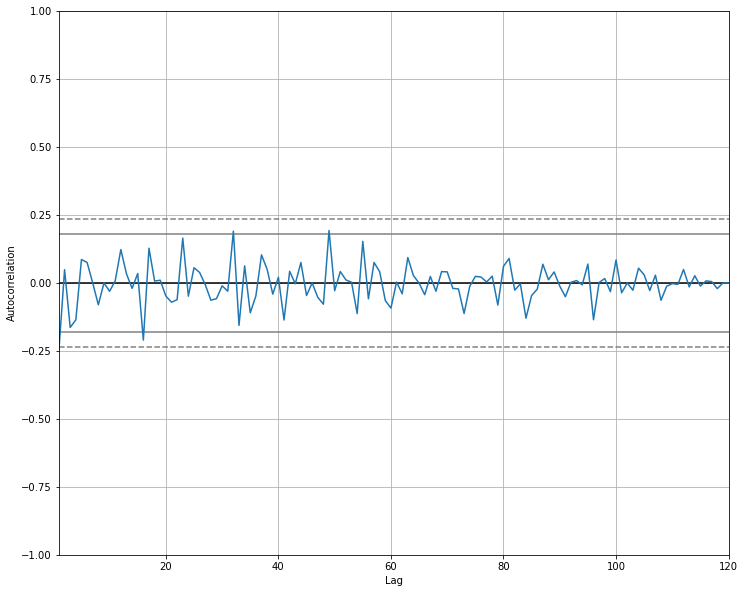

In [33]:
from pandas.plotting import autocorrelation_plot

plt.clf()
autocorrelation_plot(hw_mul.resid)
plt.show()


Y el aditivo?



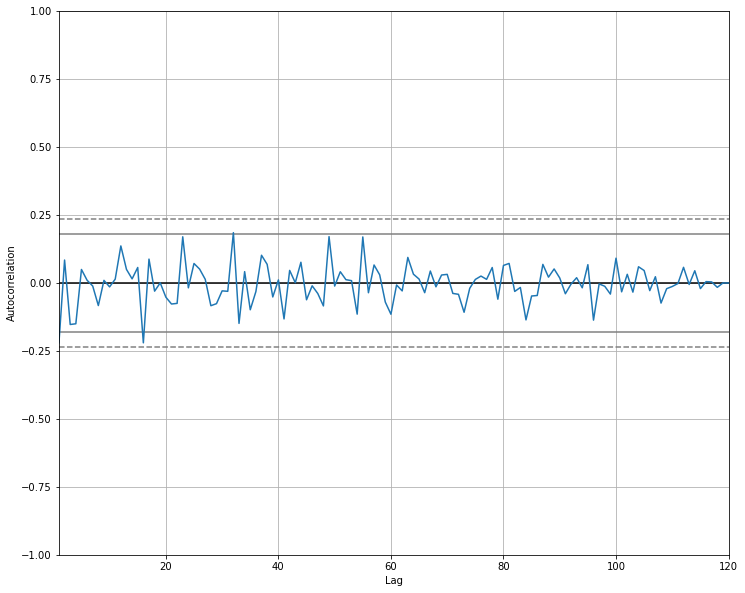

In [34]:
plt.clf()
autocorrelation_plot(hw_add.resid)
plt.show()


# Series temporales II. Modelos ARIMA


## Definición de funciones para evaluación

Vamos a reciclar y adeuar las funciones necesarias para facilitarnos la vida en el proceso de ajuste de modelos (arima y en general).

La primera puede funcionar de forma general para cualquier modelo ya que su entrada es el vector de la serie residual..así podremos usarla para culquier filtro de series que apliquemos.

La segunda es una adecuación de la función definida en la parte de suavizado para que pueda funcionar sobre auto_arima (de otro paquete) pues tiene salidas y explotación de modelo distintas. En particular, en auto_arima el *forecast* es *predict* y *resid* es *resid()*


In [35]:
import scipy.stats as stats
import seaborn as sns

# Función para evaluar residuos a través de contrastes de hipótesis
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
        
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
        
    Lags should be min(2*seasonal_period, T/5)
        
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
        
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(sm.stats.acorr_ljungbox(x=residuals, lags=lags).lb_pvalue)
    norm_p_val =  stats.jarque_bera(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
        
      
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    plt.show()
    print("** Mean of the residuals: ", np.around(resid_mean,2))
        
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), 
        "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
        
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3),
        "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
        
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), 
        "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    return ts_ax, acf_ax, kde_ax   
 
  


In [35]:
import scipy.stats as stats
import seaborn as sns

# Función para evaluar residuos a través de contrastes de hipótesis
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
        
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
        
    Lags should be min(2*seasonal_period, T/5)
        
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
        
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(sm.stats.acorr_ljungbox(x=residuals, lags=lags).lb_pvalue)
    norm_p_val =  stats.jarque_bera(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
        
      
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    plt.show()
    print("** Mean of the residuals: ", np.around(resid_mean,2))
        
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), 
        "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
        
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3),
        "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
        
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), 
        "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    return ts_ax, acf_ax, kde_ax   
 
  


In [35]:
import scipy.stats as stats
import seaborn as sns

# Función para evaluar residuos a través de contrastes de hipótesis
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
        
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
        
    Lags should be min(2*seasonal_period, T/5)
        
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
        
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(sm.stats.acorr_ljungbox(x=residuals, lags=lags).lb_pvalue)
    norm_p_val =  stats.jarque_bera(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
        
      
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    plt.show()
    print("** Mean of the residuals: ", np.around(resid_mean,2))
        
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), 
        "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
        
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3),
        "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
        
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), 
        "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    return ts_ax, acf_ax, kde_ax   
 
  


In [36]:
# Función para evaluar modelo auto_arima
def eval_model_Aarima(model,tr,tst,name='Model',lags=12):
      lb = np.mean(sm.stats.acorr_ljungbox(model.resid(), lags=lags, return_df=True).lb_pvalue)
      pred = model.predict(n_periods=len(tst))
      fig1, ax = plt.subplots()
      ax.plot(tr, label='training')
      ax.plot(tst, label='test')
      ax.plot(pred, label='prediction')
      plt.legend(loc='upper left')
      tit = name + ":  LjungBox p-value --> " + str(lb) + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
      plt.title(tit)
      plt.ylabel('Serie')
      plt.xlabel('Date')
      plt.show()
      model.plot_diagnostics(figsize=(14,10))
      plt.show()  


## Arima Manual

Podemos ajustar modelos ARIMA manuales con SARIMAX de statsmodels. Para ello, en primer lugar se deben evaluar las autodcoleraciones para identificar patrones de efectos AR y MA tentativos. Una vez tenemos una idea de los órdenes a proponer, ajustamos los modelos. 

Recordamos correlogramas de la serie logaritmica y doblemente diferenciada. 


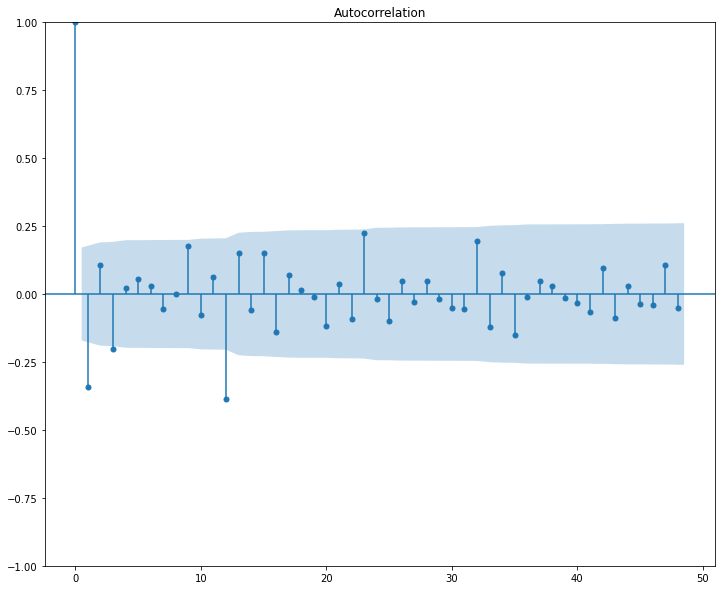

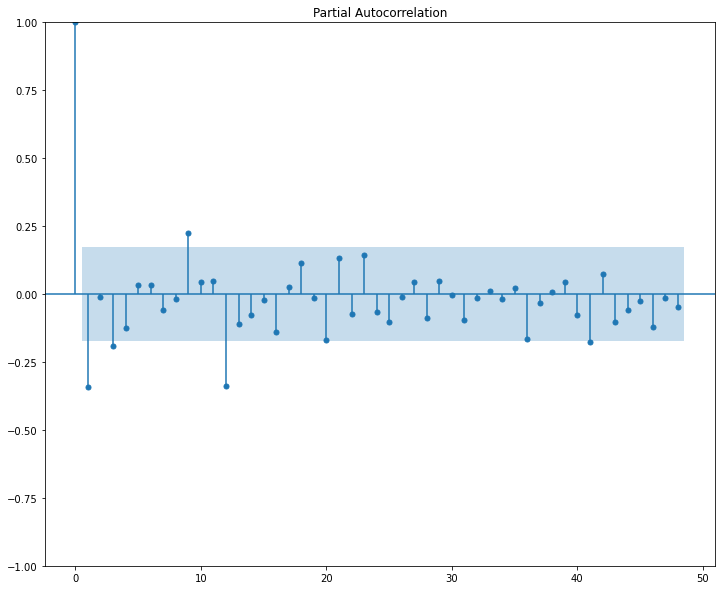

In [37]:
plot_acf(AirLog_diff_1_12.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(AirLog_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()


**ACF**: En lo regular, seguro que algo hay. Podría ser un AR si consideramos que hay decrecimiento rápido y no corte en el segundo retardo. Si es así, el órden del AR sería 1 por el corte en el pacf. En lo estacional, el retardo 12 es significativo así que algo debe haber.. No queda muy claro en si parte ar o ma.. 

**PACF**: Parece que hay un corte en el retardo 2, con lo que pensamos en AR, pero luego está ese retardo 3 con descenso..igual es un MA o un enmascaramiento de ambos. En lo estacional, de nuevo el retardo 12 jugando y no queda clara la dinámica de desaparición de las autocorrelaciones estacionales.. 

Con esto probaremos algo así como ARIMA(0-1,1,0-1)(0-1,1,0-1)[12]

**Modelo 1** -> Con ambas partes MA


In [38]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(Air_tr, 
                order = (0, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_1 = arima1.fit()
arima_1.summary()


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61648D+00    |proj g|=  4.92231D+00

At iterate    5    f= -1.63268D+00    |proj g|=  4.39031D-01

At iterate   10    f= -1.64528D+00    |proj g|=  9.78759D-01

At iterate   15    f= -1.64576D+00    |proj g|=  2.25683D-02

At iterate   20    f= -1.64587D+00    |proj g|=  1.79683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     42      1     0     0   1.780D-03  -1.646D+00
  F =  -1.6458737758798219     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 197.505
Date:                            Wed, 01 Mar 2023   AIC                           -389.010
Time:                                    17:43:31   BIC                           -380.991
Sample:                                01-01-1949   HQIC                          -385.759
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3422      0.087     -3.919      0.000      -0.513      -0.171
ma.S.L12      -0.5400      0.105     -5.151      0.000      -0.745      -0.335
sigma2         0.0014      0.000      7.865      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.93   Prob(JB):                         0.62
Heteroskedasticity (H):               0.37   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

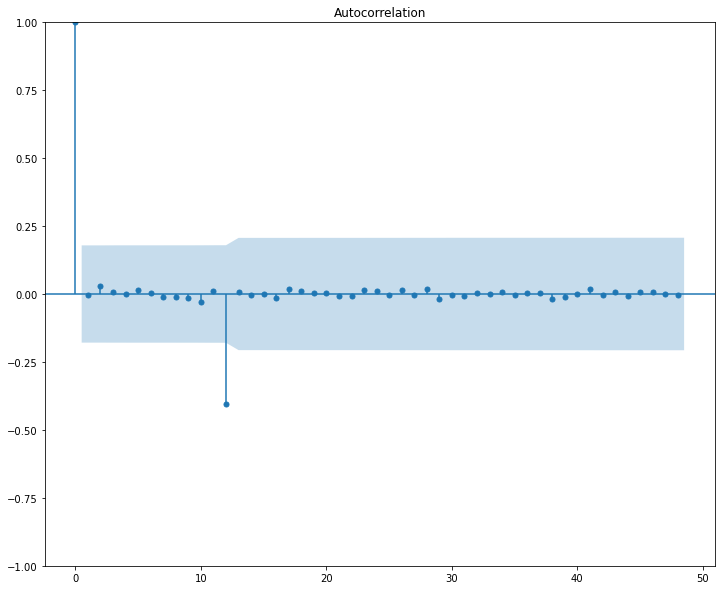

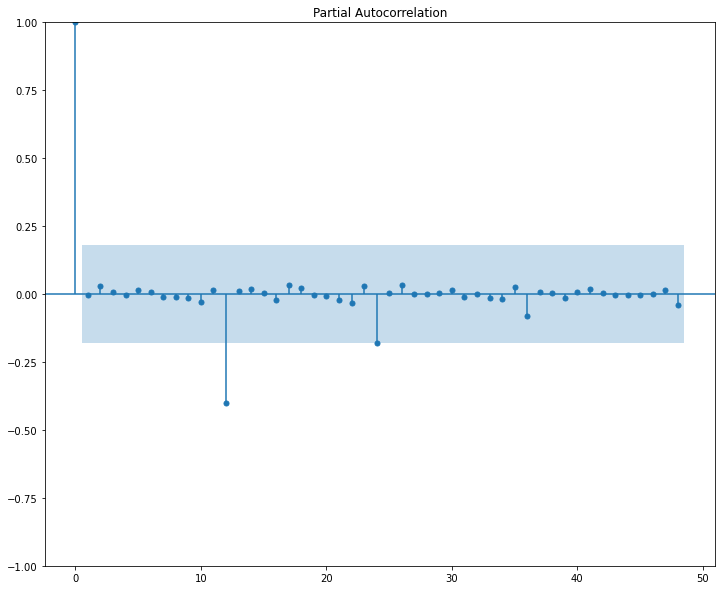

In [39]:
plot_acf(arima_1.resid,lags=48)
plt.show()
plot_pacf(arima_1.resid,lags=48,method='ywm')
plt.show()


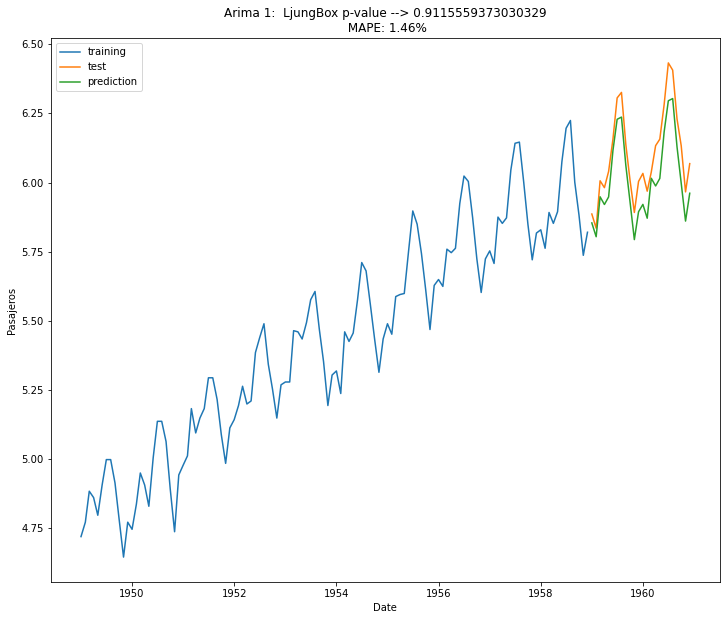

0.9115559373030329


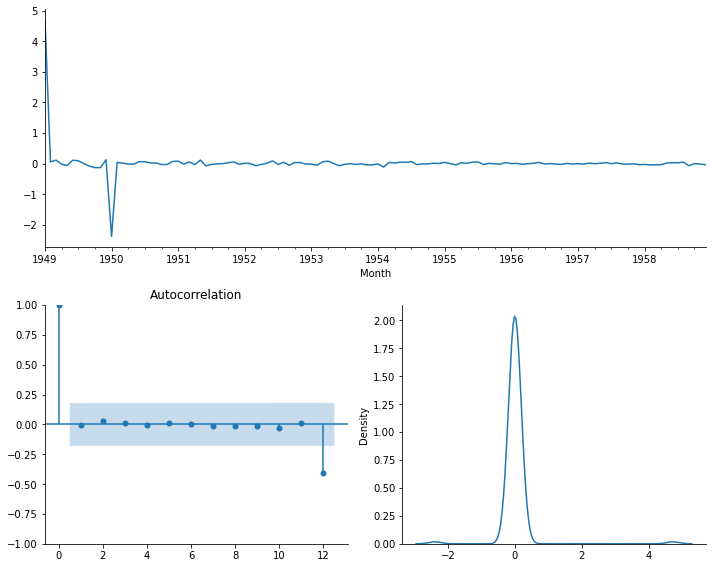

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.912 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [40]:
eval_model(arima_1,Air_tr,Air_tst,'Arima 1')

residcheck(arima_1.resid,12)


**Modelo 2** -> Con ambas partes AR



In [41]:
arima2 = SARIMAX(Air_tr, 
                order = (1, 1, 0), 
                seasonal_order =(1, 1, 0, 12))
  
arima_2 = arima2.fit()
arima_2.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61126D+00    |proj g|=  4.18988D+00

At iterate    5    f= -1.62204D+00    |proj g|=  1.57986D-02

At iterate   10    f= -1.62218D+00    |proj g|=  4.40737D-01

At iterate   15    f= -1.62232D+00    |proj g|=  1.75273D-03

At iterate   20    f= -1.62233D+00    |proj g|=  1.43637D-02

At iterate   25    f= -1.62233D+00    |proj g|=  2.91915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     45      1     0     0   

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 194.679
Date:                            Wed, 01 Mar 2023   AIC                           -383.359
Time:                                    17:43:32   BIC                           -375.340
Sample:                                01-01-1949   HQIC                          -380.108
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3482      0.079     -4.407      0.000      -0.503      -0.193
ar.S.L12      -0.4427      0.076     -5.808      0.000      -0.592      -0.293
sigma2         0.0015      0.000      7.286      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.91   Prob(JB):                         0.70
Heteroskedasticity (H):               0.33   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

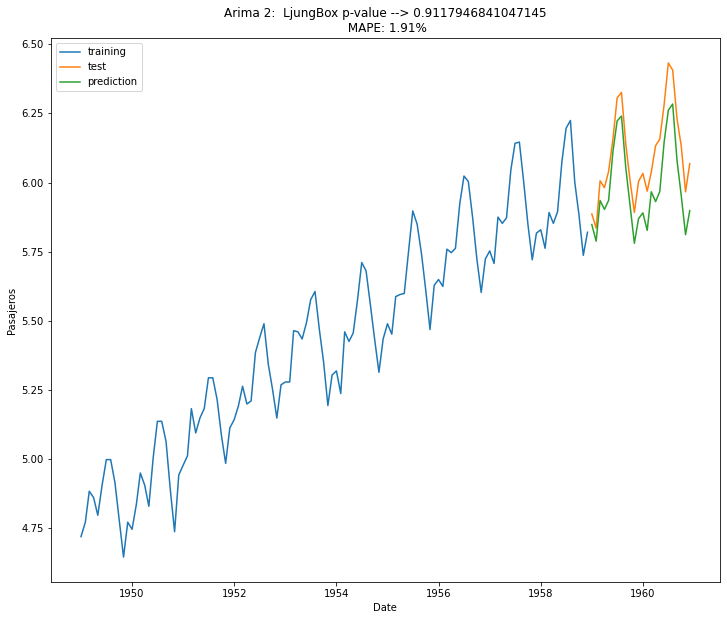

0.9117946841047145


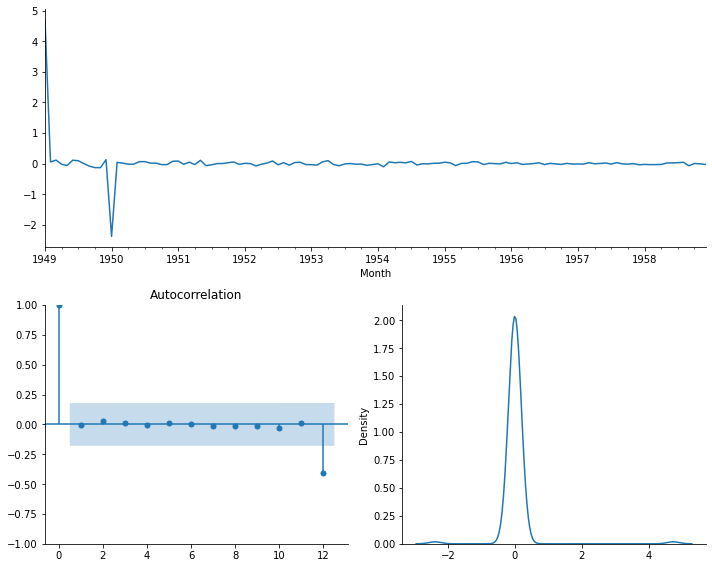

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.912 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [42]:
eval_model(arima_2,Air_tr,Air_tst,'Arima 2')

residcheck(arima_2.resid,12)


**Modelo 3** -> Superposición de efectos ARMA en regular y estacional



In [43]:
arima3 = SARIMAX(Air_tr, 
                order = (1, 1, 1), 
                seasonal_order =(1, 1, 1, 12))
  
arima_3 = arima3.fit()
arima_3.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61271D+00    |proj g|=  4.53282D+00

At iterate    5    f= -1.62809D+00    |proj g|=  1.18743D+00

At iterate   10    f= -1.63886D+00    |proj g|=  2.96477D-02

At iterate   15    f= -1.64512D+00    |proj g|=  2.67277D-02


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f= -1.64530D+00    |proj g|=  2.52188D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     36      1     0     0   7.394D-03  -1.645D+00
  F =  -1.6453042766004562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 197.437
Date:                            Wed, 01 Mar 2023   AIC                           -384.873
Time:                                    17:43:33   BIC                           -371.509
Sample:                                01-01-1949   HQIC                          -379.455
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2336      0.308     -0.759      0.448      -0.837       0.369
ma.L1         -0.0936      0.334     -0.280      0.779      -0.749       0.562
ar.S.L12      -0.0694      0.222     -0.313      0.754      -0.504       0.365
ma.S.L12      -0.4955      0.251     -1.978      0.048      -0.986      -0.005
sigma2         0.0014      0.000      7.488      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.97   Prob(JB):                         0.76
Heteroskedasticity (H):               0.36   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

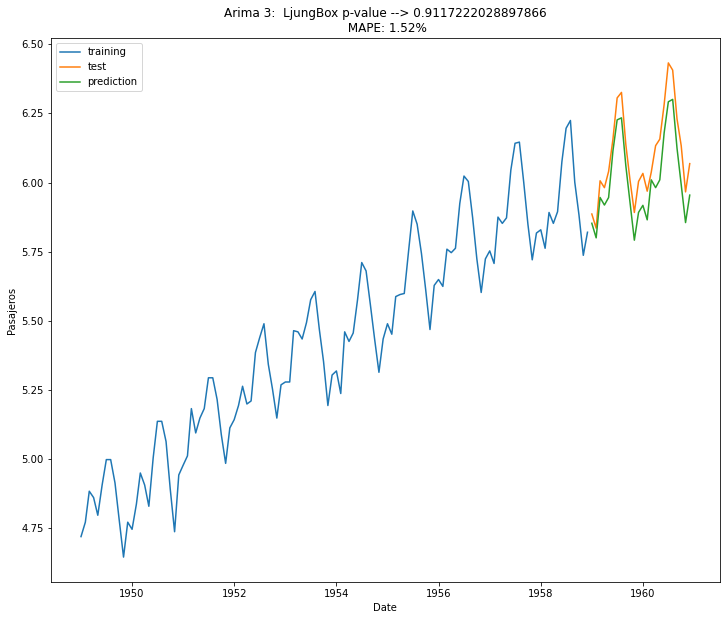

0.9117222028897866


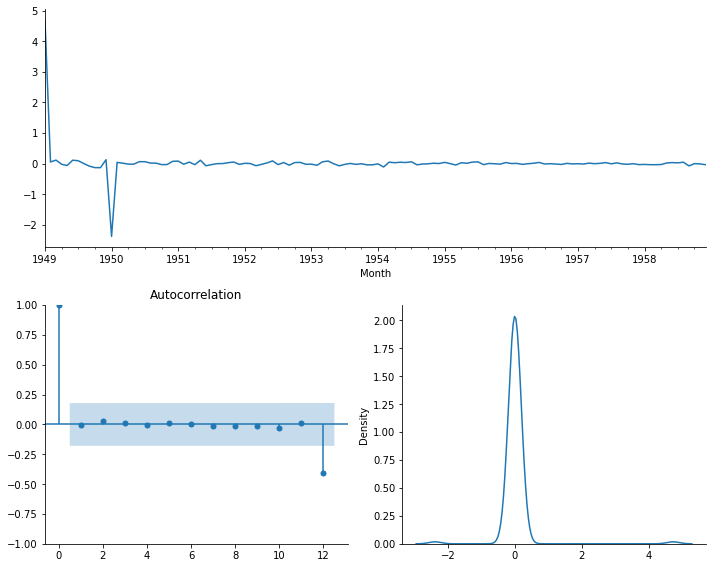

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.912 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [44]:
eval_model(arima_3,Air_tr,Air_tst,'Arima 3')
residcheck(arima_3.resid,12)


## Arima automático

En esta parte presentamos la selección de modelos arima mediante AIC que implementa el paquete *pmdarima*. Se puede jugar bastante con órdenes máximos y mínimos para los efectos autoregresivos y de medias móviles, así como con las diferenciaciones regular y estacional. 


Vamos a ajustar el mejor modelo ARIMA automático a la serie clásica de vuelos. 


In [45]:
import pmdarima as pm

# Ajustamos modelo arima step-wise con métrica AIC para la serie de vuelos
arima_auto = pm.auto_arima(Air_tr, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-384.873, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-353.412, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-383.359, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-389.010, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-364.326, Time=0.06 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-387.220, Time=0.32 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-387.254, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-384.232, Time=0.12 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-379.989, Time=0.15 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-386.675, Time=0.33 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-387.065, Time=0.43 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-388.643, Time=0.15 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-385.099, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-387.202, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 4.441 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 197.505
Date:                            Wed, 01 Mar 2023   AIC                           -389.010
Time:                                    17:43:38   BIC                           -380.991
Sample:                                01-01-1949   HQIC                          -385.759
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      

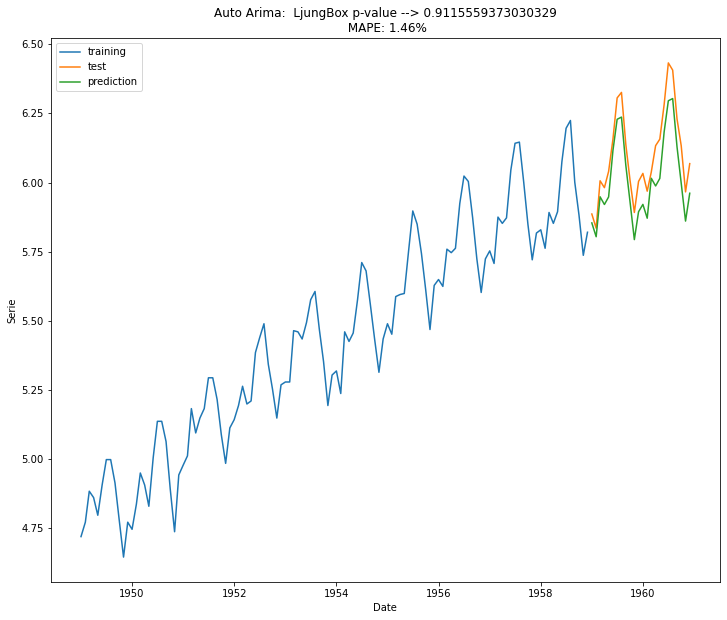

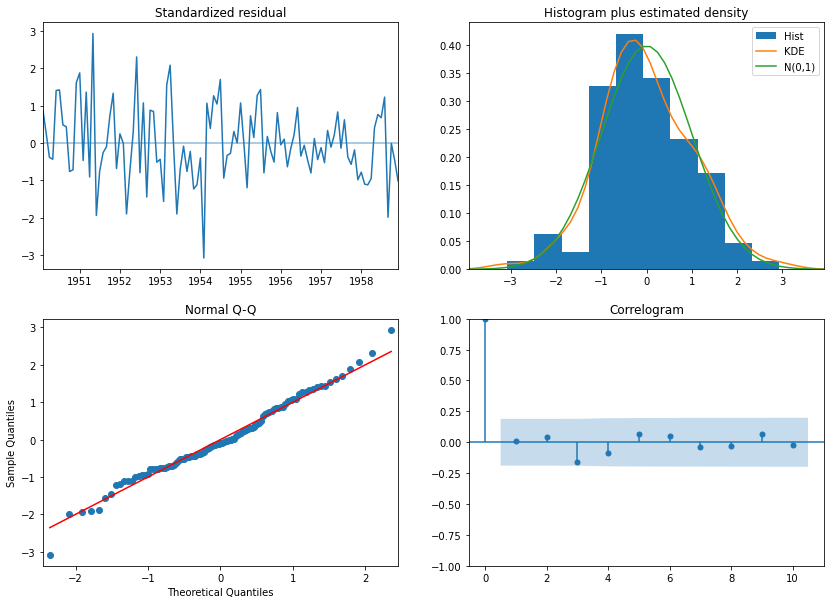

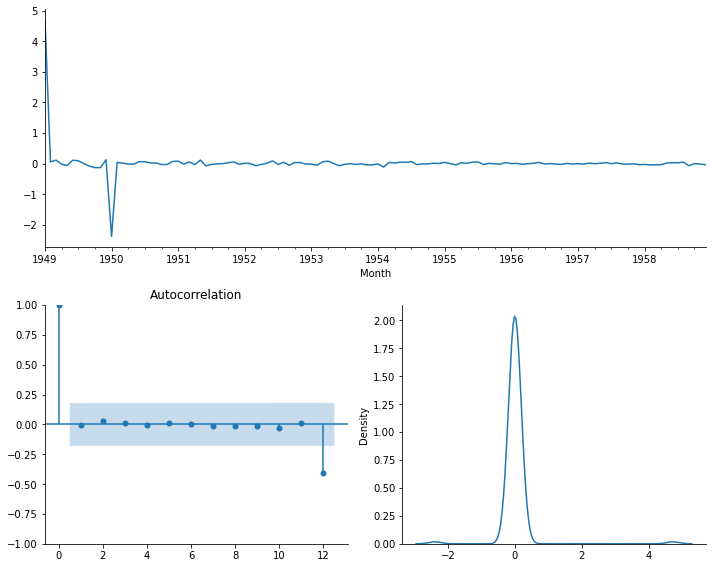

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.912 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [46]:
eval_model_Aarima(arima_auto,Air_tr,Air_tst,'Auto Arima')
residcheck(arima_auto.resid(),12)


# Aplicación a Datos sobre viajeros en la ciudad de córdoba 

Ejemplo Cordoba (datos Cordoba.xlsx), donde trataremos de explorar los mejores modelos de suavizado y arima para las dos series que contiene. 


In [47]:
#Lectura de datos
Cordoba = pd.read_excel('Cordoba.xlsx')
Cordoba.head()


V_Resident  V_Extranj
0  2005M01       27816       9332
1  2005M02       34920      11387
2  2005M03       45221      21663
3  2005M04       41027      29094
4  2005M05       50750      32076

Cambiamos la M típica del INE por un guion para generar la fecha correctamente. 



In [48]:
Cordoba['Month'] = Cordoba.iloc[:,0].apply(lambda x: x.replace('M','-'))



In [49]:
Cordoba = Cordoba.iloc[:,1:]
Cordoba.head()


V_Resident  V_Extranj    Month
0       27816       9332  2005-01
1       34920      11387  2005-02
2       45221      21663  2005-03
3       41027      29094  2005-04
4       50750      32076  2005-05

Convertir a serie temporal con la fecha indexada.



In [50]:
Cordoba.set_index(['Month'],inplace=True)
Cordoba.index=pd.to_datetime(Cordoba.index)


Veamos.



In [51]:
Cordoba.head()



V_Resident  V_Extranj
Month                            
2005-01-01       27816       9332
2005-02-01       34920      11387
2005-03-01       45221      21663
2005-04-01       41027      29094
2005-05-01       50750      32076

Tenemos la serie de viajeros residentes y la de viajeros extranjeros. Nos preguntamos si se comportan igual en cuanto al turismo en Córdoba. 



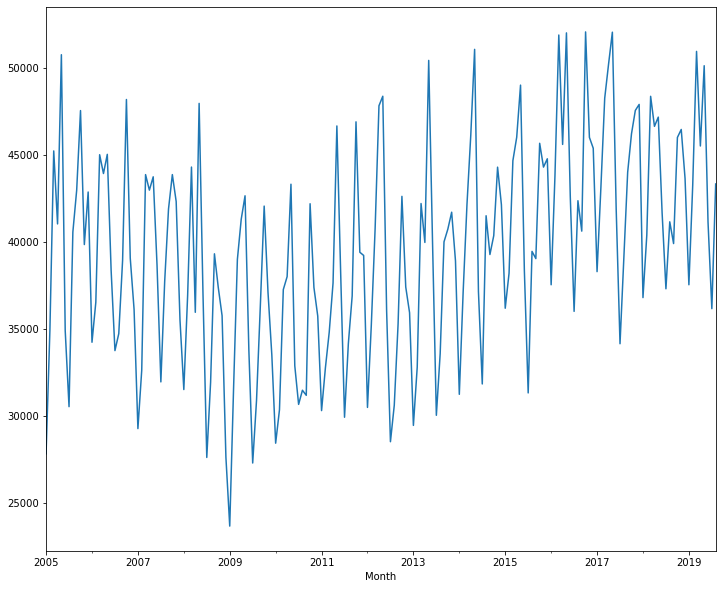

In [52]:
Cordoba.V_Resident.plot()
plt.show()


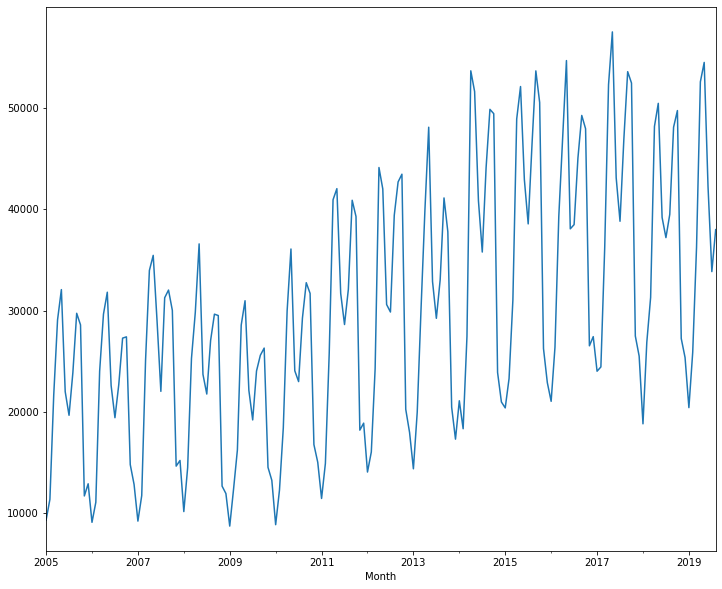

In [53]:
Cordoba.V_Extranj.plot()
plt.show()


Evaluar la estacionariedad de las series al natural.



In [54]:
test_stationarity(Cordoba.V_Extranj)
test_stationarity(Cordoba.V_Resident)


Results of Dickey-Fuller Test:
Test Statistic                  -0.926237
p-value                          0.779210
#Lags Used                      14.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -0.513405
p-value                          0.889374
#Lags Used                      12.000000
Number of Observations Used    163.000000
Critical Value (1%)             -3.471119
Critical Value (5%)             -2.879441
Critical Value (10%)            -2.576314
dtype: float64


**Descomposición multiplicativa**



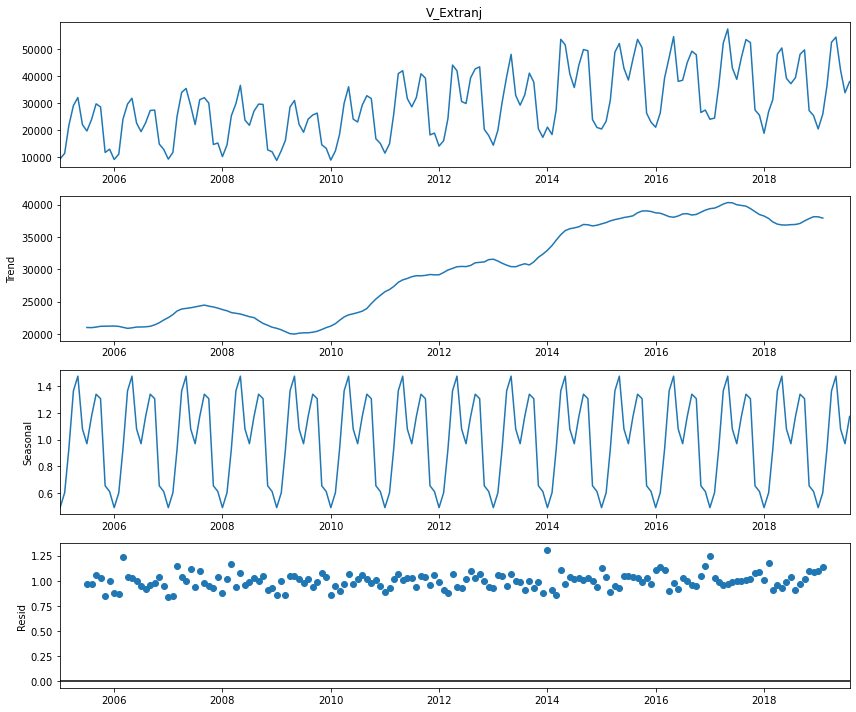

In [55]:
# Aplicar descomposición aditiva
result_E = seasonal_decompose(Cordoba.V_Extranj, model='multiplicative',period=12)
result_E.plot()
plt.show()


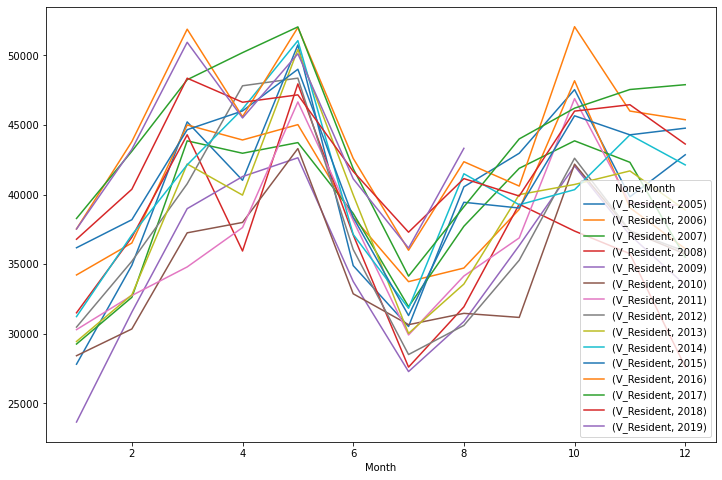

Results of Dickey-Fuller Test:
Test Statistic                -1.197623e+01
p-value                        3.796164e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.630000e+02
Critical Value (1%)           -3.471119e+00
Critical Value (5%)           -2.879441e+00
Critical Value (10%)          -2.576314e+00
dtype: float64


In [56]:
# Gráfico de estacionalidad
seasonal_plot(Cordoba)
plt.show()

# Test de estacionariedad para los residuos
test_stationarity(result_E.resid.dropna())


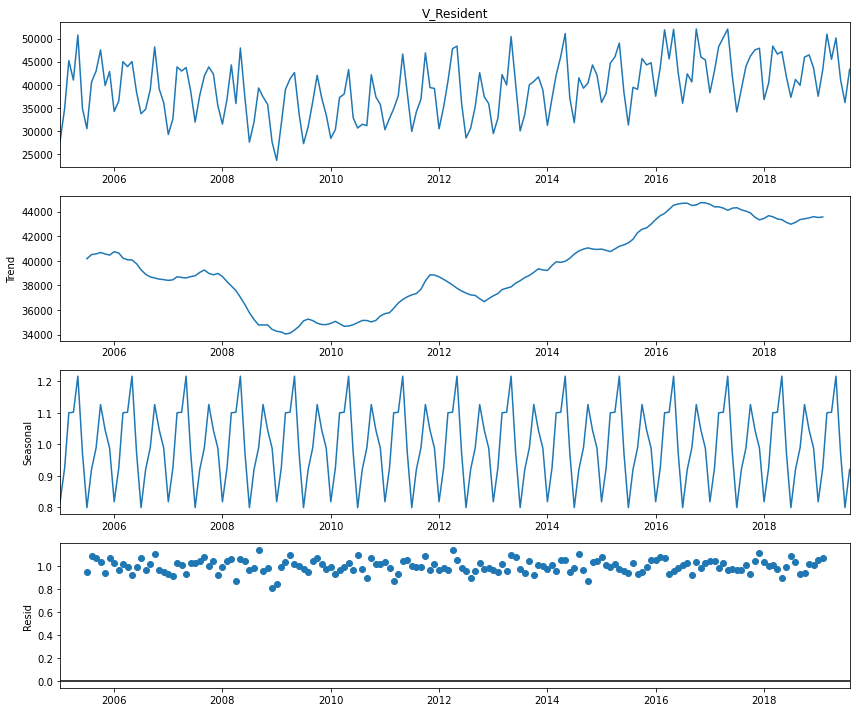

In [57]:
# Aplicar descomposición aditiva
result_R = seasonal_decompose(Cordoba.V_Resident, model='multiplicative',period=12)
result_R.plot()
plt.show()


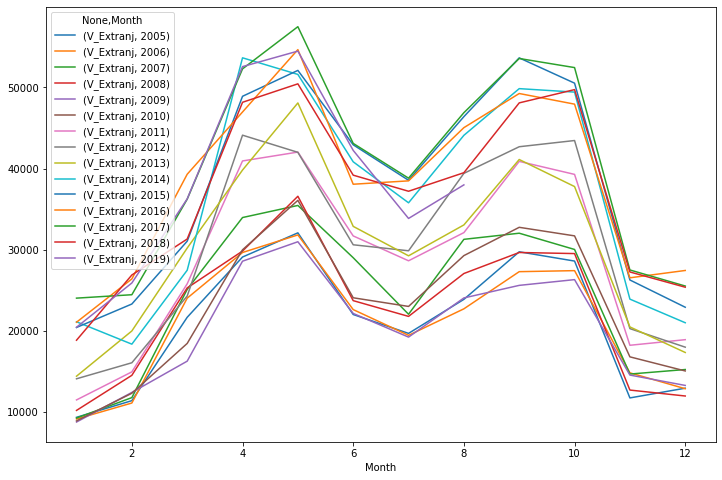

Results of Dickey-Fuller Test:
Test Statistic                -7.340774e+00
p-value                        1.066662e-10
#Lags Used                     9.000000e+00
Number of Observations Used    1.540000e+02
Critical Value (1%)           -3.473543e+00
Critical Value (5%)           -2.880498e+00
Critical Value (10%)          -2.576878e+00
dtype: float64


In [58]:
# Gráfico de estacionalidad
seasonal_plot(Cordoba,column='V_Extranj')
plt.show()

# Test de estacionariedad para los residuos
test_stationarity(result_R.resid.dropna())


Gráficos de aurocorrelación de residuos con bandas de confianza.



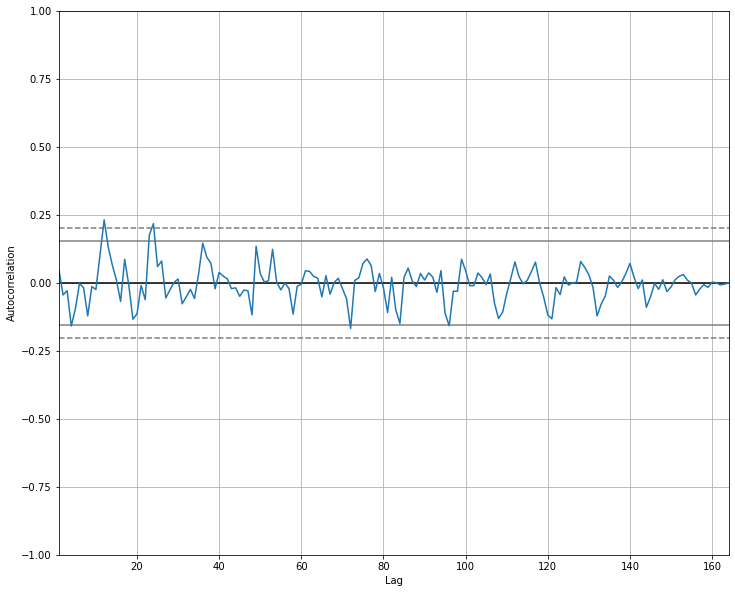

In [59]:
autocorrelation_plot(result_E.resid.dropna())
plt.show()



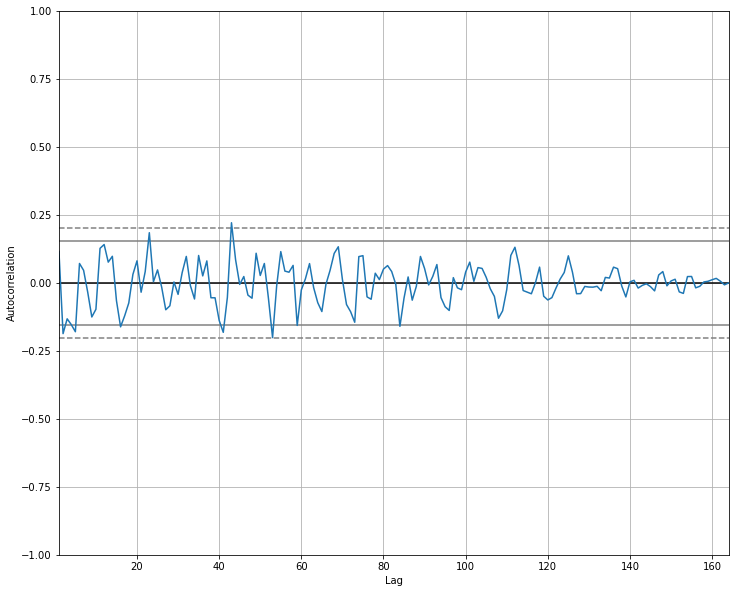

In [60]:
autocorrelation_plot(result_R.resid.dropna())
plt.show()

Contraste de Ljung-Box para residuos de la descomposición multiplicativa



In [61]:
sm.stats.acorr_ljungbox(result_E.resid.dropna(), lags=12, return_df=True)


lb_stat  lb_pvalue
1    0.390086   0.532254
2    0.715787   0.699147
3    0.851541   0.837103
4    5.112490   0.275949
5    6.650613   0.247948
6    6.651175   0.354314
7    6.705458   0.460178
8    9.249181   0.321714
9    9.280102   0.411830
10   9.381525   0.496318
11  11.289299   0.419355
12  20.972195   0.050789

In [62]:
sm.stats.acorr_ljungbox(result_R.resid.dropna(), lags=12, return_df=True)


lb_stat  lb_pvalue
1    2.237791   0.134673
2    8.071325   0.017674
3   11.011894   0.011662
4   14.998395   0.004705
5   20.502372   0.001005
6   21.391819   0.001560
7   21.768829   0.002784
8   21.966624   0.004978
9   24.710894   0.003308
10  26.363710   0.003281
11  29.257182   0.002070
12  32.849279   0.001022

**Partición training-test**



In [63]:
Cordoba_tr = Cordoba[:'2017-12-01']
Cordoba_tst = Cordoba['2018-01-01':]


## Modelos de Suavizado

En esta sección vamos a ajustar modelos de suavizado que parezcar realistas para estas series. Es evidente que nada de simple y doble y nos vamos a Holt Winters. Vamos a probar aditivo y multiplicativo para ambas series.

1. **Extranjeros**

Modelo aditivo.


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


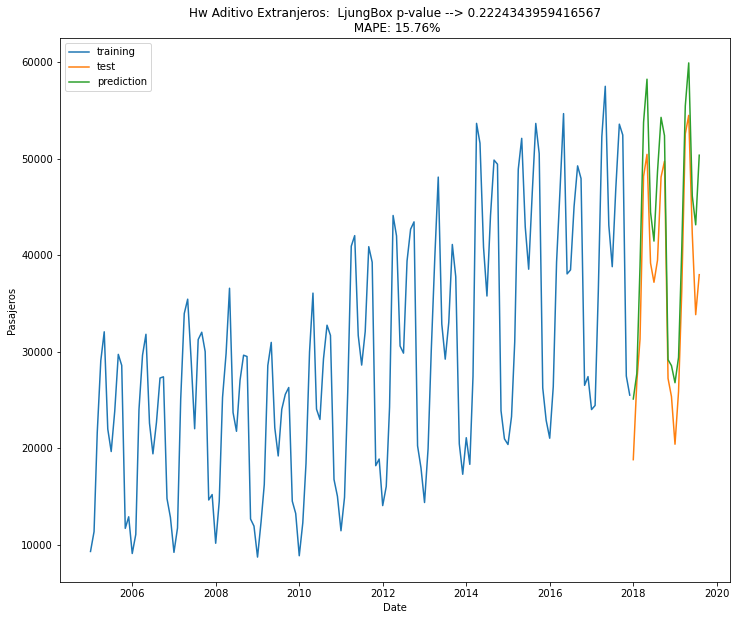

0.2224343959416567


In [64]:
hw_add = ets.ExponentialSmoothing(Cordoba_tr.V_Extranj,trend='add', damped_trend=False, seasonal='add').fit()
eval_model(hw_add,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Hw Aditivo Extranjeros')


Modelo multiplicativo. 



/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


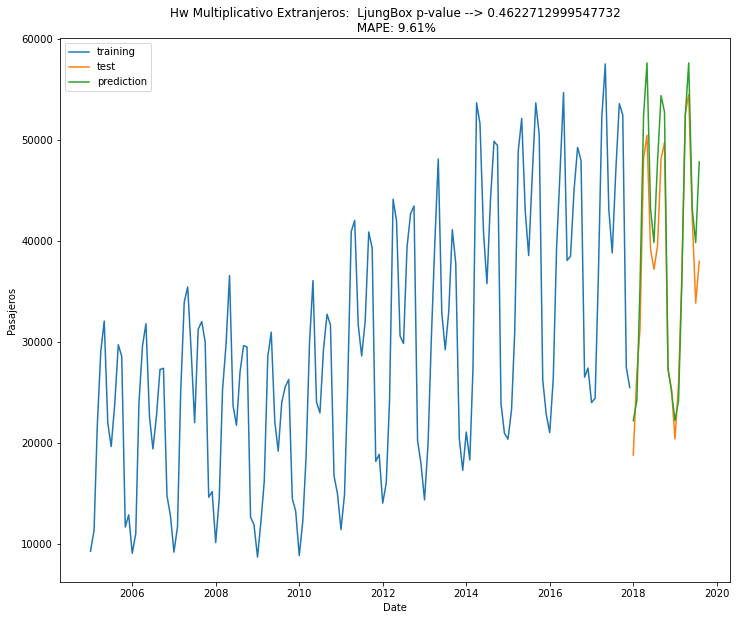

0.4622712999547732


In [65]:
hw_mul = ets.ExponentialSmoothing(Cordoba_tr.V_Extranj,trend='mul', damped_trend=False, seasonal='mul').fit()
eval_model(hw_mul,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Hw Multiplicativo Extranjeros')


2. **Residentes**

Modelo aditivo.


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


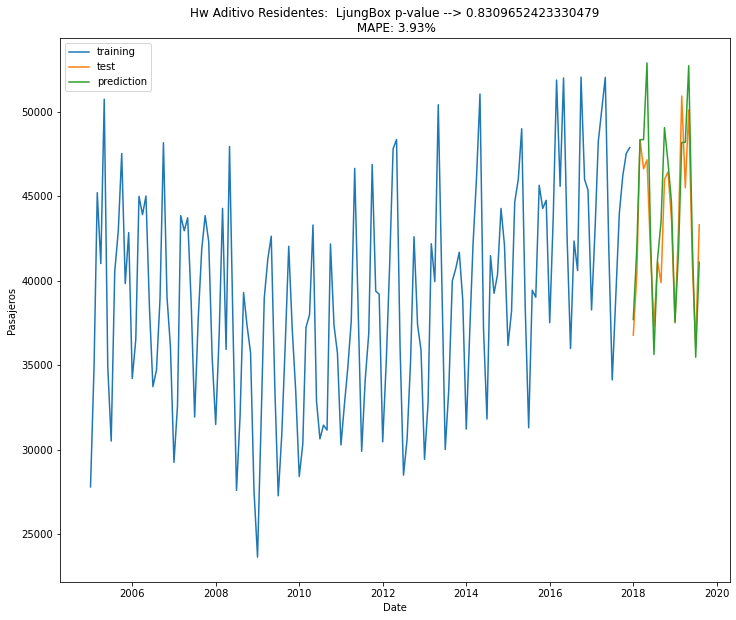

0.8309652423330479


In [66]:
hw_add = ets.ExponentialSmoothing(Cordoba_tr.V_Resident,trend='add', damped_trend=False, seasonal='add').fit()
eval_model(hw_add,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Hw Aditivo Residentes')


Modelo multiplicativo.



/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


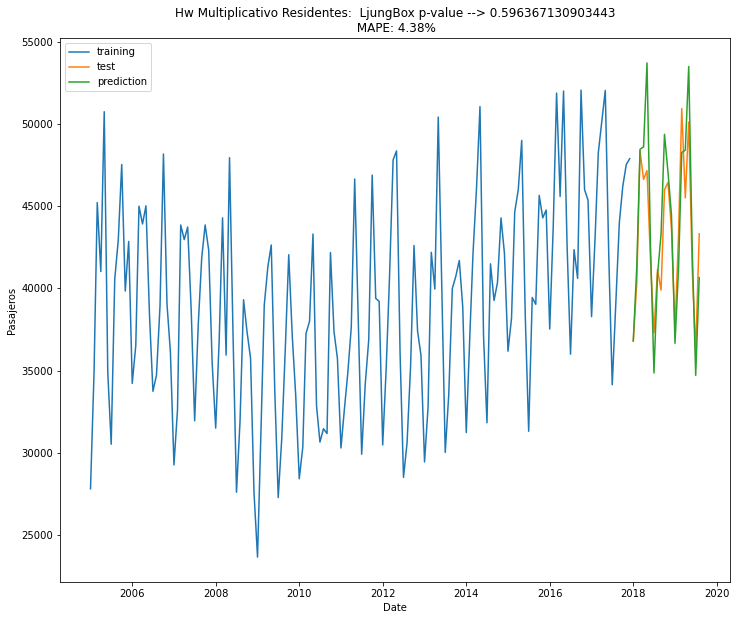

0.596367130903443


In [67]:
hw_mul = ets.ExponentialSmoothing(Cordoba_tr.V_Resident,trend='mul', damped_trend=False, seasonal='mul').fit()
eval_model(hw_mul,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Hw Multiplicativo Residentes')


## Modelos ARIMA

1. **Extranjeros**

Vistazo a correlogramas.


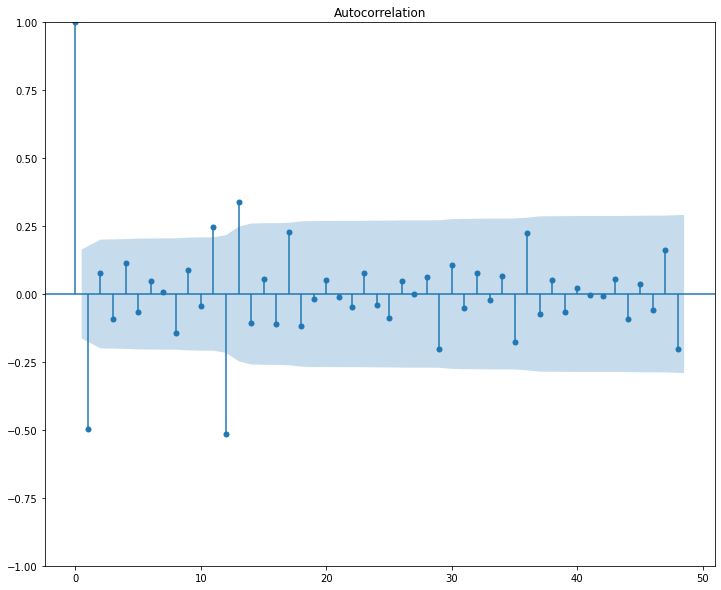

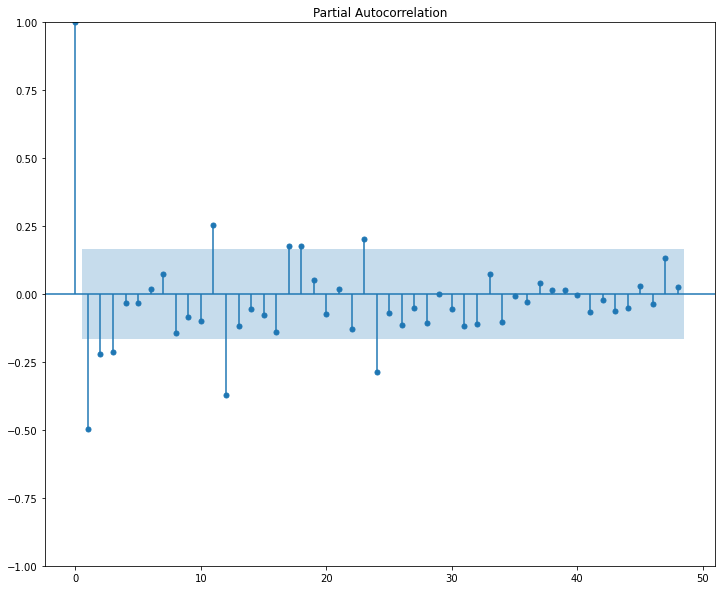

In [68]:
Extranj_diff_1_12 = Cordoba_tr.V_Extranj.diff(periods=1).diff(periods=12)

plot_acf(Extranj_diff_1_12.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(Extranj_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()


ACF que se corta en retardo 1, parece Ma 1 en lo regular. También hay corte en retardo 12, huele a MA 1 estacional. 
PACF confirma un poco las sospechas, podríamos decir decrecimiento geométrico en lo regular pero podría haber bajada desde el retardo 1 por lo que podría enmascarar un AR 1.. En lo estacional, decrecimiento, parece MA. 

Asi pues, podemos proponer algo como ARIMA(0-1,1,1)(0,1,1)[12] y jugar un poco por ahí. 


**Arima Manual**


In [69]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(Cordoba_tr.V_Extranj, 
                order = (0, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_1 = arima1.fit()
arima_1.summary()


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72420D+00    |proj g|=  1.67521D-01

At iterate    5    f=  8.66186D+00    |proj g|=  6.81142D-05

At iterate   10    f=  8.66185D+00    |proj g|=  1.98060D-03

At iterate   15    f=  8.66070D+00    |proj g|=  2.36065D-02

At iterate   20    f=  8.64352D+00    |proj g|=  2.14688D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   4.071D-07   8.643D+00
  F =   8.6425319545706039     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          V_Extranj   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1348.235
Date:                            Wed, 01 Mar 2023   AIC                           2702.470
Time:                                    17:43:44   BIC                           2711.359
Sample:                                01-01-2005   HQIC                          2706.082
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5649      0.058     -9.741      0.000      -0.679      -0.451
ma.S.L12      -0.4795      0.065     -7.352      0.000      -0.607      -0.352
sigma2      8.663e+06   7.82e+05     11.085      0.000    7.13e+06    1.02e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                17.18
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             0.40
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

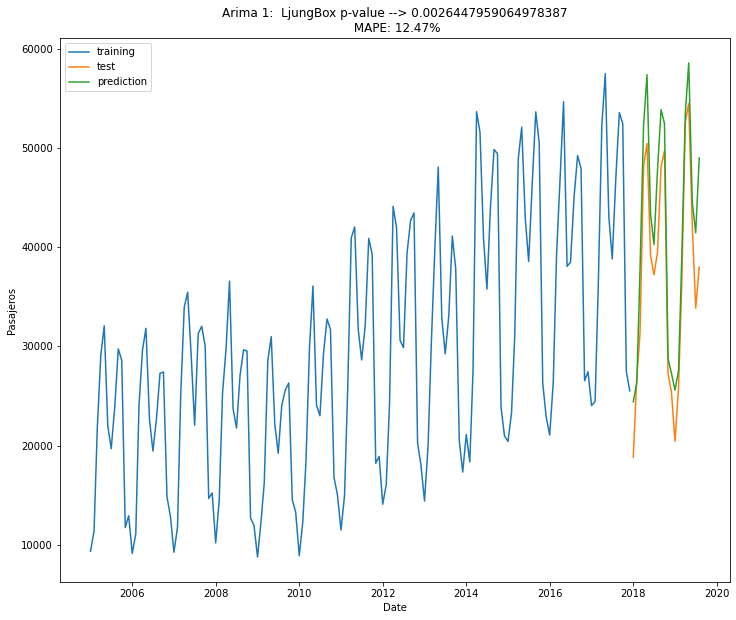

0.0026447959064978387


In [70]:
eval_model(arima_1,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Arima 1')



In [71]:
arima2 = SARIMAX(Cordoba_tr.V_Extranj, 
                order = (1, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_2 = arima2.fit()
arima_2.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72730D+00    |proj g|=  1.77992D-01

At iterate    5    f=  8.66088D+00    |proj g|=  1.04232D-03

At iterate   10    f=  8.66087D+00    |proj g|=  6.80357D-05

At iterate   15    f=  8.66087D+00    |proj g|=  1.51895D-03

At iterate   20    f=  8.66043D+00    |proj g|=  1.71113D-02


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  8.64720D+00    |proj g|=  7.36449D-02

At iterate   30    f=  8.64166D+00    |proj g|=  2.76104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     34      1     0     0   2.584D-06   8.642D+00
  F =   8.6416579726258593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          V_Extranj   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1348.099
Date:                            Wed, 01 Mar 2023   AIC                           2704.197
Time:                                    17:43:44   BIC                           2716.049
Sample:                                01-01-2005   HQIC                          2709.013
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0793      0.158      0.503      0.615      -0.230       0.389
ma.L1         -0.6163      0.119     -5.182      0.000      -0.849      -0.383
ma.S.L12      -0.4903      0.068     -7.202      0.000      -0.624      -0.357
sigma2      8.643e+06   7.85e+05     11.013      0.000    7.11e+06    1.02e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                18.82
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             0.40
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

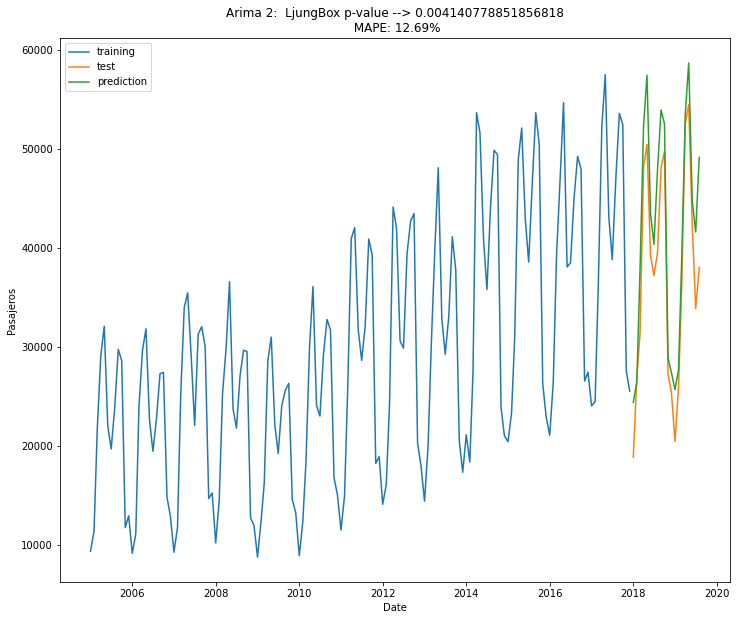

0.004140778851856818


In [72]:
eval_model(arima_2,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Arima 2')



Probamos adiferenciar de orden 2 en lo regular.



In [73]:
arima3 = SARIMAX(Cordoba_tr.V_Extranj, 
                order = (1, 2, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_3 = arima3.fit()
arima_3.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81990D+00    |proj g|=  9.81152D-02

At iterate    5    f=  8.72654D+00    |proj g|=  1.13489D-02

At iterate   10    f=  8.71951D+00    |proj g|=  5.61835D-03

At iterate   15    f=  8.71913D+00    |proj g|=  8.17085D-05

At iterate   20    f=  8.71905D+00    |proj g|=  3.01686D-03


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  8.70027D+00    |proj g|=  1.20898D-01

At iterate   30    f=  8.67304D+00    |proj g|=  2.14261D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     35      1     0     0   1.220D-07   8.673D+00
  F =   8.6730416906685903     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          V_Extranj   No. Observations:                  156
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood               -1352.995
Date:                            Wed, 01 Mar 2023   AIC                           2713.989
Time:                                    17:43:45   BIC                           2725.812
Sample:                                01-01-2005   HQIC                          2718.794
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3485      0.082     -4.234      0.000      -0.510      -0.187
ma.L1         -1.0000      0.086    -11.639      0.000      -1.168      -0.832
ma.S.L12      -0.5095      0.073     -6.968      0.000      -0.653      -0.366
sigma2      1.064e+07   8.08e-09   1.32e+15      0.000    1.06e+07    1.06e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                18.96
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.39
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.26e+29. Standard errors may be unstable.
"""

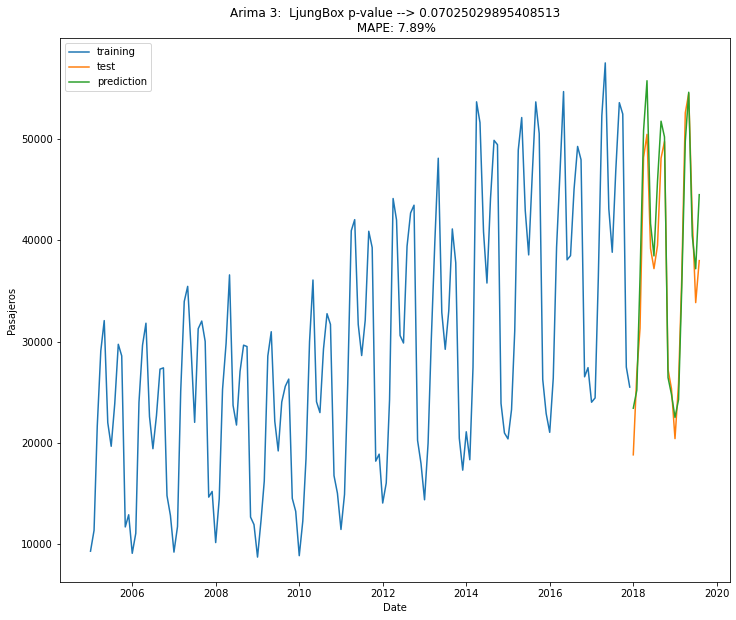

0.07025029895408513


In [74]:
eval_model(arima_3,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Arima 3')



Auto ARIMA 

Vamos a aplicar automatismos para buscar los mejores órdenes en relación al AIC utilizando auro_arima.


In [75]:
# Auto arima
arima_auto = pm.auto_arima(Cordoba_tr.V_Extranj, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=2924.228, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=2807.137, Time=0.09 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=2837.587, Time=0.04 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,2,0)(2,1,0)[12]             : AIC=2799.067, Time=0.19 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=2800.645, Time=0.36 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=2794.444, Time=0.27 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=2799.773, Time=0.12 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,2,0)(1,1,2)[12]             : AIC=inf, Time=1.18 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,2,0)(0,1,2)[12]             : AIC=2793.990, Time=0.61 sec
 ARIMA(0,2,0)(0,1,2)[12]             : AIC=2859.093, Time=0.42 sec
 ARIMA(2,2,0)(0,1,2)[12]             : AIC=2770.998, Time=0.67 sec
 ARIMA(2,2,0)(0,1,1)[12]             : AIC=2775.698, Time=0.14 sec
 ARIMA(2,2,0)(1,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=2776.946, Time=0.15 sec
 ARIMA(3,2,0)(0,1,2)[12]             : AIC=2761.174, Time=0.47 sec
 ARIMA(3,2,0)(0,1,1)[12]             : AIC=2759.331, Time=0.17 sec
 ARIMA(3,2,0)(0,1,0)[12]             : AIC=2786.522, Time=0.07 sec
 ARIMA(3,2,0)(1,1,1)[12]             : AIC=2761.234, Time=0.19 sec
 ARIMA(3,2,0)(1,1,0)[12]             : AIC=2766.210, Time=0.14 sec
 ARIMA(3,2,0)(1,1,2)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(4,2,0)(0,1,1)[12]             : AIC=2749.704, Time=0.18 sec
 ARIMA(4,2,0)(0,1,0)[12]             : AIC=2779.810, Time=0.09 sec
 ARIMA(4,2,0)(1,1,1)[12]             : AIC=2751.081, Time=0.23 sec
 ARIM

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,2,1)(2,1,0)[12]             : AIC=2722.711, Time=2.27 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,2,1)(1,1,0)[12]             : AIC=2729.426, Time=1.02 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,2,1)(2,1,0)[12]             : AIC=2710.667, Time=2.01 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,2,1)(1,1,0)[12]             : AIC=2730.286, Time=0.42 sec
 ARIMA(4,2,1)(2,1,1)[12]             : AIC=inf, Time=2.19 sec
 ARIMA(4,2,1)(1,1,1)[12]             : AIC=2726.846, Time=0.36 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,2,1)(2,1,0)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(4,2,0)(2,1,0)[12]             : AIC=2748.441, Time=0.39 sec
 ARIMA(4,2,2)(2,1,0)[12]             : AIC=2720.632, Time=1.99 sec
 ARIMA(3,2,0)(2,1,0)[12]             : AIC=2759.100, Time=0.32 sec
 ARIMA(3,2,2)(2,1,0)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(5,2,2)(2,1,0)[12]             : AIC=2721.852, Time=1.67 sec
 ARIMA(4,2,1)(2,1,0)[12] intercept   : AIC=2725.514, Time=1.61 sec

Best model:  ARIMA(4,2,1)(2,1,0)[12]          
Total fit time: 36.028 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  156
Model:             SARIMAX(4, 2, 1)x(2, 1, [], 12)   Log Likelihood               -1347.334
Date:                             Wed, 01 Mar 2023   AIC                           2710.667
Time:                                     17:44:21   BIC                           2734.314
Sa

/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


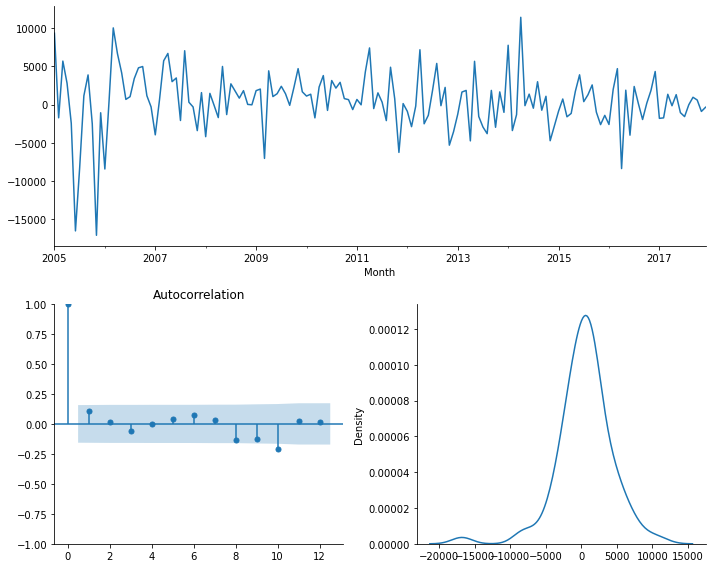

** Mean of the residuals:  478.39

** Ljung Box Test, p-value: 0.449 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:xlabel='Month'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [76]:
residcheck(arima_auto.resid(),12)



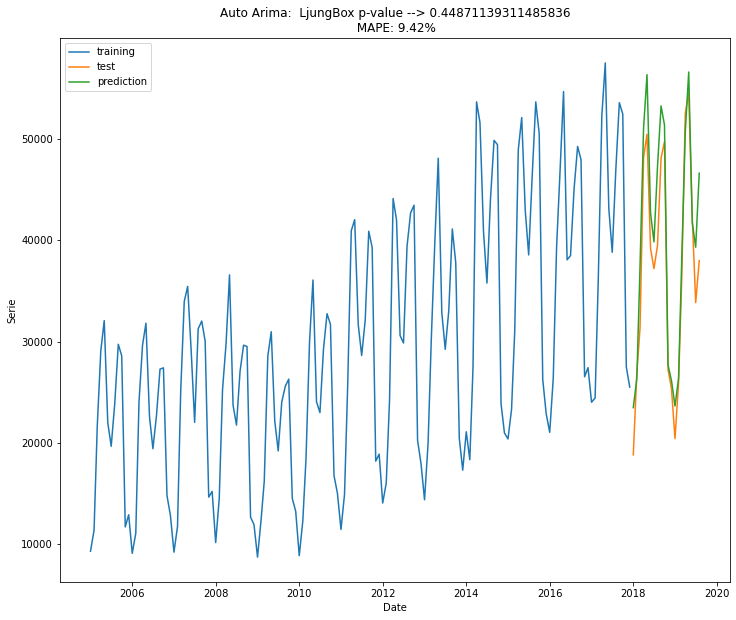

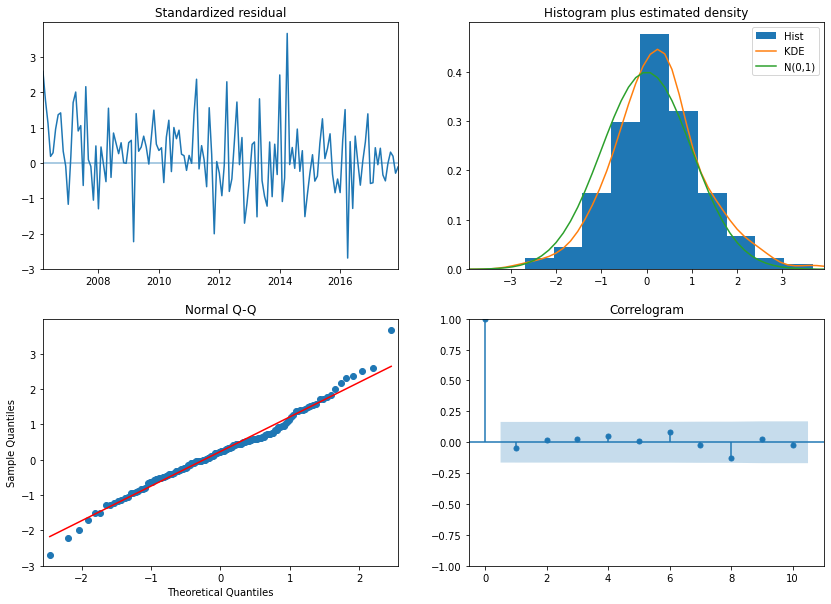

In [77]:
eval_model_Aarima(arima_auto,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Auto Arima')



2. **Residentes**

Vistazo a correlogramas.


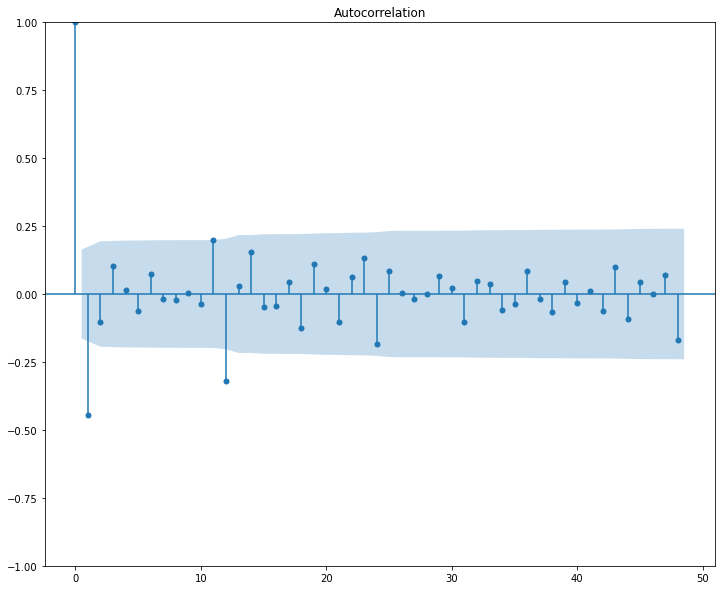

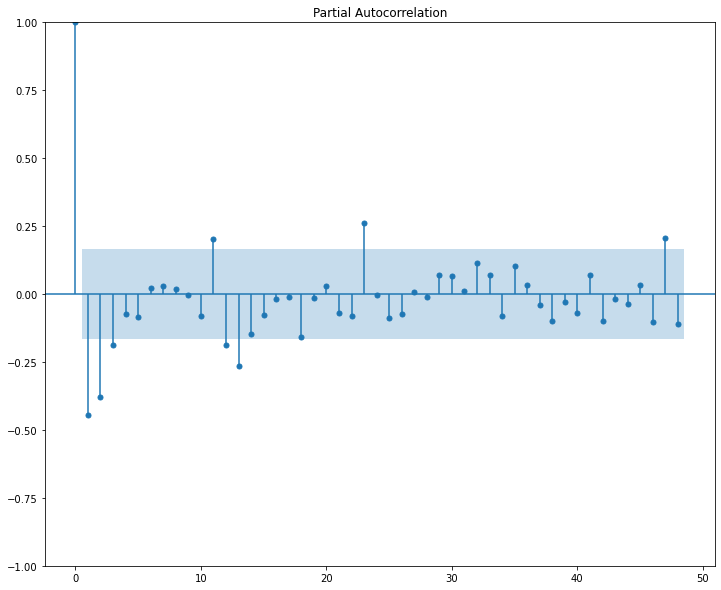

In [78]:
Resid_diff_1_12 = Cordoba_tr.V_Resident.diff(periods=1).diff(periods=12)

plot_acf(Resid_diff_1_12.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(Resid_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()


Parte AR de orden 2 enmascarada por parte MA de orden 1 en lo regular. 

Parte AR de orden 1-2 enmascarada por algo de MA seguramente en lo estacional

Por esto nuestros candidatos a ajustar serían: ARIMA(2,1,1)(1-2,1,0-1-2)[12], o cualquiera de sus variaciones en las porsiciones autoregresivas o de medias móviles.

**Arima Manual**


In [79]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(Cordoba_tr.V_Resident, 
                order = (2, 1, 1), 
                seasonal_order =(1, 1, 0, 12))
  
arima_1 = arima1.fit()
arima_1.summary()


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93239D+00    |proj g|=  5.08153D-01

At iterate    5    f=  8.82000D+00    |proj g|=  2.81966D-02

At iterate   10    f=  8.81922D+00    |proj g|=  2.65564D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   2.656D-05   8.819D+00
  F =   8.8192232962219332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          V_Resident   No. Observations:                  156
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1375.799
Date:                             Wed, 01 Mar 2023   AIC                           2761.598
Time:                                     17:44:22   BIC                           2776.412
Sample:                                 01-01-2005   HQIC                          2767.617
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2956      0.474     -0.623      0.533      -1.225       0.634
ar.L2         -0.1721      0.165     -1.042      0.297      -0.496       0.152
ma.L1         -0.0796      0.465     -0.171      0.864      -0.991       0.831
ar.S.L12      -0.3116      0.032     -9.781      0.000      -0.374      -0.249
sigma2       1.17e+07   3.79e-08   3.09e+14      0.000    1.17e+07    1.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.22   Jarque-Bera (JB):                 2.09
Prob(Q):                              0.04   Prob(JB):                         0.35
Heteroskedasticity (H):               0.52   Skew:                            -0.25
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.79e+30. Standard errors may be unstable.
"""

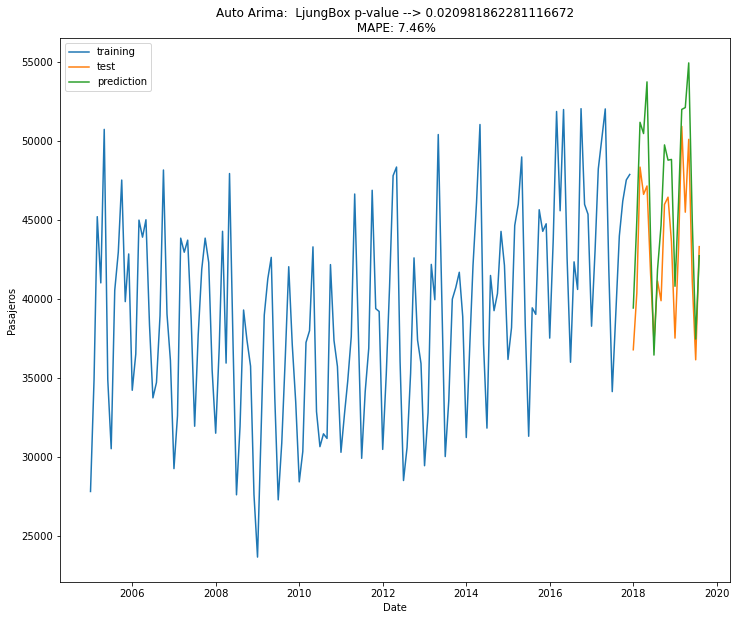

0.020981862281116672


In [80]:
eval_model(arima_1,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')



In [81]:
arima2 = SARIMAX(Cordoba_tr.V_Resident, 
                order = (2, 1, 1), 
                seasonal_order =(2, 1, 0, 12))
  
arima_2 = arima2.fit()
arima_2.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92388D+00    |proj g|=  5.84045D-01

At iterate    5    f=  8.76307D+00    |proj g|=  9.46866D-03


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  8.76082D+00    |proj g|=  1.10483D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   1.489D-04   8.761D+00
  F =   8.7607460400927906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          V_Resident   No. Observations:                  156
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1366.676
Date:                             Wed, 01 Mar 2023   AIC                           2745.353
Time:                                     17:44:23   BIC                           2763.130
Sample:                                 01-01-2005   HQIC                          2752.577
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3586      0.522     -0.688      0.492      -1.381       0.664
ar.L2         -0.1811      0.159     -1.136      0.256      -0.494       0.131
ma.L1          0.0342      0.511      0.067      0.947      -0.967       1.035
ar.S.L12      -0.4374      0.045     -9.614      0.000      -0.527      -0.348
ar.S.L24      -0.2620      0.048     -5.462      0.000      -0.356      -0.168
sigma2       1.17e+07   6.82e-08   1.72e+14      0.000    1.17e+07    1.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.80   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.05   Prob(JB):                         0.61
Heteroskedasticity (H):               0.57   Skew:                            -0.15
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+30. Standard errors may be unstable.
"""

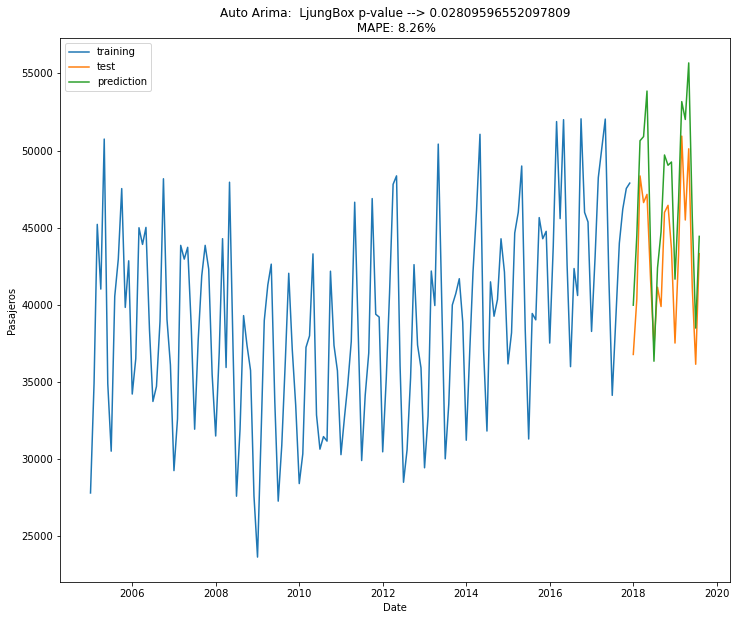

0.02809596552097809


In [82]:
eval_model(arima_2,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')



In [83]:
arima3 = SARIMAX(Cordoba_tr.V_Resident, 
                order = (2, 1, 1), 
                seasonal_order =(1, 1, 1, 12))
  
arima_3 = arima2.fit()
arima_3.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92388D+00    |proj g|=  5.84045D-01

At iterate    5    f=  8.76307D+00    |proj g|=  9.46866D-03


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  8.76082D+00    |proj g|=  1.10483D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   1.489D-04   8.761D+00
  F =   8.7607460400927906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          V_Resident   No. Observations:                  156
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1366.676
Date:                             Wed, 01 Mar 2023   AIC                           2745.353
Time:                                     17:44:24   BIC                           2763.130
Sample:                                 01-01-2005   HQIC                          2752.577
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3586      0.522     -0.688      0.492      -1.381       0.664
ar.L2         -0.1811      0.159     -1.136      0.256      -0.494       0.131
ma.L1          0.0342      0.511      0.067      0.947      -0.967       1.035
ar.S.L12      -0.4374      0.045     -9.614      0.000      -0.527      -0.348
ar.S.L24      -0.2620      0.048     -5.462      0.000      -0.356      -0.168
sigma2       1.17e+07   6.82e-08   1.72e+14      0.000    1.17e+07    1.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.80   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.05   Prob(JB):                         0.61
Heteroskedasticity (H):               0.57   Skew:                            -0.15
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+30. Standard errors may be unstable.
"""

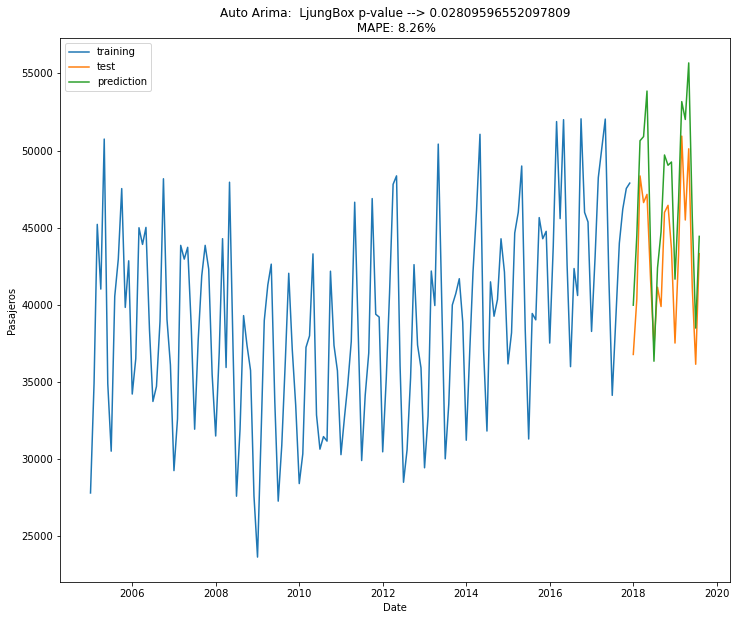

0.02809596552097809


In [84]:
eval_model(arima_3,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')



Auto ARIMA 

Vamos a aplicar automatismos para buscar los mejores órdenes en relación al AIC utilizando auro_arima.


In [85]:
# Auto arima
arima_auto = pm.auto_arima(Cordoba_tr.V_Resident, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2738.430, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2800.896, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2764.647, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2738.776, Time=0.09 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2740.007, Time=0.14 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2760.748, Time=0.12 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=2739.076, Time=0.38 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=2738.623, Time=0.47 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2784.782, Time=0.15 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2737.511, Time=0.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2736.400, Time=0.42 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2737.503, Time=0.46 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2737.312, Time=0.15 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2748.778, Time=0.52 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2736.726, Time=0.49 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,2)[12]             : AIC=2739.833, Time=0.76 sec


/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,2)[12]             : AIC=2738.388, Time=0.88 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=2738.012, Time=0.49 sec

Best model:  ARIMA(0,1,1)(0,1,2)[12]          
Total fit time: 6.496 seconds
                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1364.200
Date:                                 Wed, 01 Mar 2023   AIC                           2736.400
Time:                                         17:44:31   BIC                           2748.251
Sample:                                     01-01-2005   HQIC                          2741.216
                                          - 12-01-2017                                         
Covariance Type:                                   opg                                         
                 coe

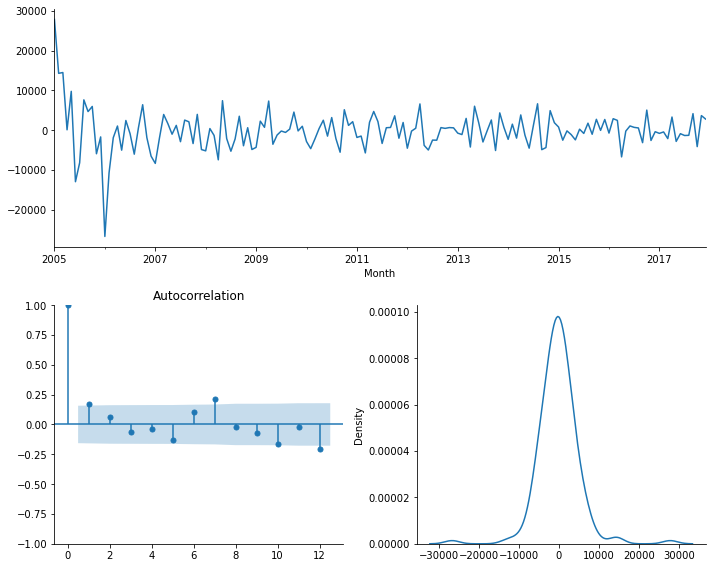

** Mean of the residuals:  -163.04

** Ljung Box Test, p-value: 0.057 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


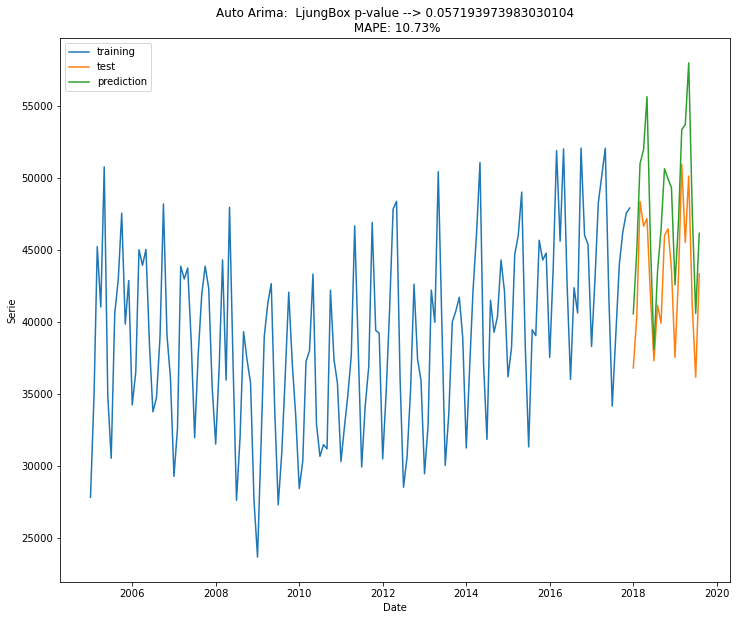

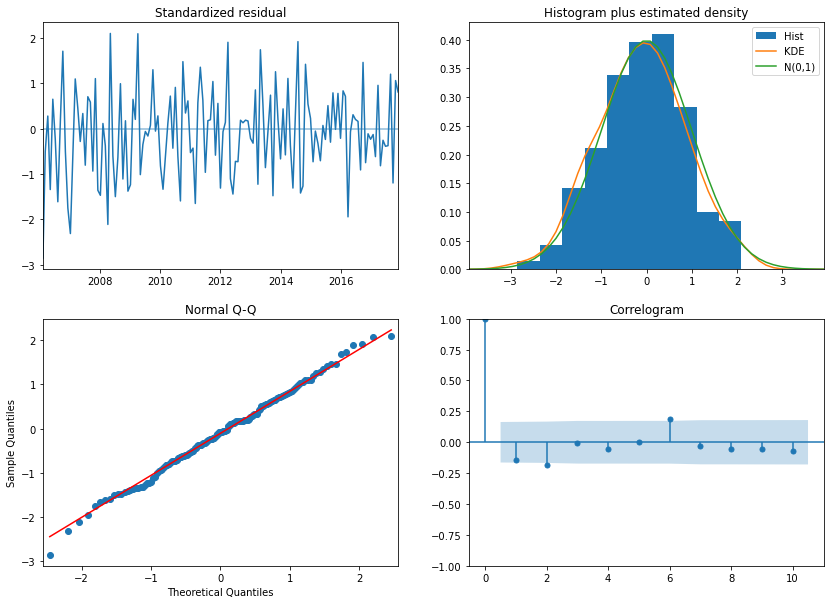

In [86]:
residcheck(arima_auto.resid(),12)
eval_model_Aarima(arima_auto,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')


In [87]:
from prophet import Prophet

#Lectura de datos
Cordoba = pd.read_excel('C:\\Users\\Guille\\Documents\\MineriaDatos_2022_23\\Datos\\Cordoba.xlsx')
Cordoba.head()

Cordoba['Month'] = pd.to_datetime(Cordoba.iloc[:,0].apply(lambda x: x.replace('M','-')))


Cordoba.iloc[:,1:].head()

ModuleNotFoundError: No module named 'prophet'

In [ ]:
cord_res = Cordoba[['Month','V_Resident']]

cord_res.columns = ['ds', 'y']
cord_res.head()

In [ ]:
cord_res_tr = cord_res[cord_res.ds <= '2017-12-01']
cord_res_tst = cord_res[cord_res.ds > '2017-12-01']



In [ ]:
cord_res_tst

In [ ]:
p = Prophet(interval_width=0.92, daily_seasonality=True)
p = p.fit(cord_res_tr)



In [ ]:
forecast_prediction = p.predict(cord_res_tst)
forecast_prediction.tail()

In [ ]:
plot1 = p.plot(forecast_prediction)

In [ ]:
plot2 = p.plot_components(forecast_prediction)

In [ ]:
eval_model(p,cord_res_tr,cord_res_tst,'Prophet')

In [ ]:
# Función para evaluar modelo
def eval_model(model,tr,tst,name='Model',lags=12):
    #lb = np.mean(sm.stats.acorr_ljungbox(model.resid, lags=lags, return_df=True).lb_pvalue)
    pred = model.predict(tst)
    fig1, ax = plt.subplots()
    ax.plot(tr, label='training')
    ax.plot(tst, label='test')
    ax.plot(pred, label='prediction')
    plt.legend(loc='upper left')
    tit = name + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
    plt.title(tit)
    plt.ylabel('Residentes')
    plt.xlabel('Date')
    plt.show()
    print(lb)